# Personal Networks Assignment

In [1]:
import pandas as pd
import numpy as np
import networkx as nx 
import community
from networkx.algorithms.community import k_clique_communities
import community
import matplotlib.pyplot as plt
import os
# for block modelling 
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

In [2]:
pns = 'data/egos/' # as downloaded from LEARN with no manual modifications

In [3]:
students = {}
for root, dirlist, filelist in os.walk(pns):
    for filename in filelist:
        if 'csv' in filename:
            full = os.path.join(root, filename)
            who = full.split('-')[2:4]
            surname = who[0].split(' ')
            surname = surname[1]
            snum = who[1].replace(' ','')
            who = f'{surname}_{snum}'
            students[who] = full

In [4]:
def construct_network(path):
    df = pd.read_csv(path)
    ego = df['Unnamed: 0'].loc[0]
    df.set_index('Unnamed: 0', inplace=True)
    df.reset_index()
    df.fillna(0, inplace=True)
    df
    g = nx.from_pandas_adjacency(df)
    g.remove_node(ego)
    return g

In [5]:
problems = []
graphs = {}

for k,v in students.items():
    try:
        g = construct_network(v)
        graphs[k] = g
    except:
        #print(f"Problem with {k}'s data.")
        problems.append(k)

In [6]:
print(f'There are problems with {len(problems)} files.')

There are problems with 0 files.


In [7]:
# students

# Processing Individual Submissions

In [38]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return(x,y)    
    
    
def louvain(g, layout, student_graph):
    comps = sorted(nx.connected_components(g), key=len, reverse=True)
    giant = g.subgraph(comps[0])
    g = giant

    partition = community.best_partition(g)
    modularity = community.modularity(partition, g)
    
    colors = [partition[n] for n in g.nodes()]
    my_colors = plt.cm.Set2
    
    fig, ax = plt.subplots(figsize=(20,15))
    nx.draw_networkx_nodes(g,pos=layout, node_size=500, node_color=colors, cmap = my_colors) 
    nx.draw_networkx_edges(g, pos=layout, width=2, edge_color='lightgray', alpha=.9)
    nx.draw_networkx_labels(g, pos=layout, font_size=10)
    plt.title('Giant Component')
    plt.axis('off')    
    plt.savefig(f'personal_networks/{student_graph}_louvain.png', dpi=300, bbox_inches='tight',pad_inches = .1)
    plt.close()
    
    return comps
    
    
def node_level(g, student_graph):
    d = nx.degree_centrality(g)
    b = nx.betweenness_centrality(g)
    e = nx.eigenvector_centrality(g, max_iter=600)
    triangles = nx.triangles(g)
    df = pd.DataFrame([triangles, d, e, b]).T
    df.columns = ['Number of Closed Triads (Triangles)', 'Degree Centrality', 'Eigenvector Centrality', 'Betweenness Centrality']
    df = df.sort_values('Number of Closed Triads (Triangles)', ascending = False)
    
    xd, yd = ecdf(pd.Series(pd.Series(d)))
    xe, ye = ecdf(pd.Series(pd.Series(e)))
    xb, yb = ecdf(pd.Series(pd.Series(b)))

    fig,ax = plt.subplots(figsize=(12,8))
    ax.scatter(xd,yd, c='#32363A', alpha=.6, s=50, marker='o', label='Degree Centrality')
    ax.scatter(xe,ye, c='crimson', alpha=.6, s=50, marker='o', label='Eigenvector Centrality')
    ax.scatter(xb,yb, c='orange', alpha=.6, s=50, marker='o', label='Betweenness Centrality')

    # interquartile range with median
    ax.set_yticks([0,.25, .5, .75, 1])
    ax.set_xticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.1])

    ax.axhline(.5, c='darkgray', linewidth=2) # central tendency: median value
    ax.axhline(.25, c='darkgray', linestyle="--", linewidth=2) # 25th percentile
    ax.axhline(.75, c='darkgray', linestyle="--", linewidth=2) # 75th percentile

    plt.xlabel('Centrality')
    plt.ylabel('Cumulative Fraction')
    plt.xlim(-.02, 1.1)
    plt.legend(loc='lower right')
    
    plt.savefig(f'personal_networks/{student_graph}_ecdf.png', dpi=600, bbox_inches='tight',pad_inches = .02)
    plt.close()
    
    return df, df.to_markdown()



def assignment_1(student_graph):
    print(f'Processing {student_graph}...')
    g = graphs[student_graph]
    layout = nx.kamada_kawai_layout(g)
    
    # see(g, layout, student_graph)
    comps = louvain(g, layout, student_graph)
    
    # overlap, anykcc, kcce = kcliques(g)
    # highlight_kclique(g, layout, anykcc, kcce, student_graph)
    
    df, dfm = node_level(g, student_graph)    
    
    with open(f'personal_networks/{student_graph}.md', 'w') as f:
        # f.write(f'\n\n![](personal_networks/{student_graph}_intro.png)\n\n')
        f.write(f'# Personal Network ({student_graph})\n\n')
        f.write(f'## General Instructions \n\n This assignment requires you to answer three sets of related questions. Each is embedded in the text below. Please limit yourself to approximately 200 words per question set. If you require a little more or a little less, that is OK. **Write your answers directly in this document** and then upload it to the Learn dropbox.\n\nEverything you need to know to answer the questions in this assignment to our satisfaction is contained in the assigned readings and the lecture videos on social networks. However, if there is anything you are unsure about, please do not hesitate to reach out to me or one of the Teaching Assistants if you have questions.\n\n - John\n\n')
        f.write(f'**UPDATE:** When I initially sent this assignment, I (a) included you in the network and (b) used a $k$-clique community detection to see if you would reason through the implicaitons of leaving you in the network. Given the number of students who are interested in seeing the stucture of their networks (a) without themselves in it and (b) using a different community detection approach, I changed the analysis. **You can use this version for your assignment or the one I previously shared. The choice is yours.**')
        f.write(f'\n\n# Centrality Analysis\n\n')
        f.write('The table below provdes the number of closed triads (simply triangles, since this is an undirected network) that each node in your personal network is embedded in, as well as their degree centrality, eigenvector centrality, and betweenness centrality (calculated using shortest paths). The table is sorted so that the most embedded nodes (i.e. in the most triangles) appear first.\n\n')
        f.write('\n\n')
        f.write(dfm)
        f.write('\n\n')
        f.write('**Question Set 1**: How do these results compare to your previous expectations? Do any nodes have higher or lower degree, eigenvector, or betweenness centrality that you expected? Why or why not? Are there any people in your personal network that are more (or less) embedded than you previously expected?\n\n')
        f.write('> *Write your answer here...* Please try to limit yourself to about 200 words.\n\n')
        f.write(f'The plot below shows the distribution of degree centrality, eigenvector centrality, and degree centrality scores. It is an ECDF plot (like the ones I have been using in the lectures) that shows the full spread of the data, and highlights the 25th, 50th, and 75th percentiles with horizontal gray lines.\n\n**Question Set 2**: Building on your answers to the previous question set, please interpret this graph. In general (i.e. beyond any specific person), what does this graph tell you about how well-connected the people in your network are? Are there any surprises here for you? If so, what and why are they surprising? If not, why is this not surprising to you?\n\n')
        f.write('> *Write your answer here...* Please try to limit yourself to about 200 words.\n\n')
        f.write(f'![ECDF of Centrality Scores](personal_networks/{student_graph}_ecdf.png)')
        f.write('\n\n# Cohesive Subgroups\n\n')    
        f.write('The figure below highlights classifies nodes into different communities using the Louvain community detection approach discussed in the lecture on cohesive subgroups. Recall from the lecture that a community is a cluster of nodes where the connections within the community are denser to connections to nodes external to the community. One of the limitations of this method is that a node can only be assigned to one community.\n\n')

        if len(comps) > 1:
            f.write('When you are removed from the network, the following nodes are disconnected from the "giant component" (which is the largest group of connected nodes in the network, and is what is shown in the figure below). When these disconnected nodes are on their own, we usually call them "isolates" (but you can also call them a "component," just not the *giant* component.).\n\n')
            for i,g in enumerate(comps[1:]):
                f.write(f'Component {i+1}: {list(g)}')
        
        f.write(f'![Louvain Community Detection](personal_networks/{student_graph}_louvain.png)\n\n')
        f.write('**Question Set 3**: Are these the cohesive subgroups that you would expect to see? Why or why not? Are nodes part of clusters that you would expect them to be in? Are there communities in this network that are *not* captured by the Louvain community analysis? Why do you think they were not identified by the analysis conducted here?')
        f.write('\n\n> *Write your answer here...* Please try to limit yourself to about 200 words.\n\n')
    
        # f.write(f'The figure below highlights all of the nodes and edges that are embedded in $k$-clique communities ($k$ = 3). Recall from the lecture that a $k$-clique community (a) consists of at least one clique where all nodes are connected to $k$ other nodes, and (b) which may overlap with other $k$-cliques. One of the strenghs of $k$-clique analysis is that single nodes can be part of multiple $k$-cliques. As you can see in the figure below, there are {len(anykcc)} $k$-clique communities in your personal network.\n\n')
        
        # if len(anykcc) > 1:
            # f.write(f'These are the nodes that are embedded in at least one $k$-clique: {anykcc}.\n\n')
        
        # f.write(f'![$k$-clique analysis](personal_networks/{student_graph}_kcc.png)\n\n')
        # f.write('**Question Set 3**: Are these the cohesive subgroups that you would expect to see? Why or why not? Are nodes part of clusters that you would expect them to be in? Are there communities in this network that are *not* captured by the $k$-clique community analysis? Why do you think they were not identified by the analysis conducted here?')
        # f.write('\n\n> *Write your answer here...* Please try to limit yourself to about 200 words.\n\n')
            
    command = f'pandoc --reference-doc=template.docx personal_networks/{student_graph}.md -o personal_networks/{student_graph}.docx'
    os.system(command)
    print(f'Finished processing {student_graph}')

    del g # whipe the slate clean for the next student...

In [10]:
image_path = '/Users/johnmclevey/Documents/work/teaching/courses/INTEG120/assignments/egos/block_models/'

def equiv(student_graph):
    g = graphs[student_graph]
    ego_am = nx.adjacency_matrix(g)
    distances = euclidean_distances(ego_am)
    
    Z = hierarchy.linkage(distances, 'ward')
    
    plt.figure(figsize=(12, 10))
    plt.title('Hierarchical Clustering of Structural Profiles')
    plt.xlabel('Distance (Lower Scores Indicate More Structural Similarity)')

    d = hierarchy.dendrogram(
        Z,
        distance_sort=True,
        leaf_rotation=0,  # rotates the x axis labels
        leaf_font_size=8,  # font size for the x axis labels
        orientation='right', 
        labels = [n for n in g.nodes()])
    
    plt.savefig(f'{image_path}{student_graph}.pdf', bbox_inches='tight',pad_inches = 0.5)    

<ipython-input-8-14ad051e2f9f>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(distances, 'ward')


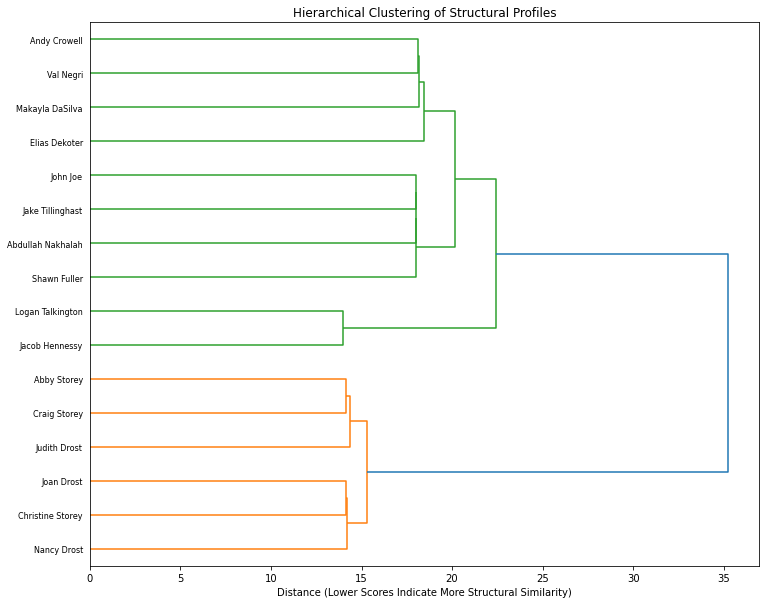

In [9]:
equiv('Storey_20900576')

# Assignment 1

In [ ]:
# issues = []

# for k, v in graphs.items():
#     try:
#         assignment_1(k)
#     except:
#         issues.append(k)

# Assignment 2

<ipython-input-10-14ad051e2f9f>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(distances, 'ward')
<ipython-input-10-14ad051e2f9f>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(distances, 'ward')
<ipython-input-10-14ad051e2f9f>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(distances, 'ward')
<ipython-input-10-14ad051e2f9f>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(distances, 'ward')
<ipython-input-10-14ad051e2f9f>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspici

<ipython-input-10-14ad051e2f9f>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(distances, 'ward')
<ipython-input-10-14ad051e2f9f>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 10))
<ipython-input-10-14ad051e2f9f>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(distances, 'ward')
<ipython-input-10-14ad051e2f9f>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much mem

<ipython-input-10-14ad051e2f9f>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(distances, 'ward')
<ipython-input-10-14ad051e2f9f>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 10))
<ipython-input-10-14ad051e2f9f>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(distances, 'ward')
<ipython-input-10-14ad051e2f9f>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much mem

<ipython-input-10-14ad051e2f9f>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(distances, 'ward')
<ipython-input-10-14ad051e2f9f>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 10))
<ipython-input-10-14ad051e2f9f>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(distances, 'ward')
<ipython-input-10-14ad051e2f9f>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much mem

<ipython-input-10-14ad051e2f9f>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(distances, 'ward')
<ipython-input-10-14ad051e2f9f>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 10))
<ipython-input-10-14ad051e2f9f>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(distances, 'ward')
<ipython-input-10-14ad051e2f9f>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much mem

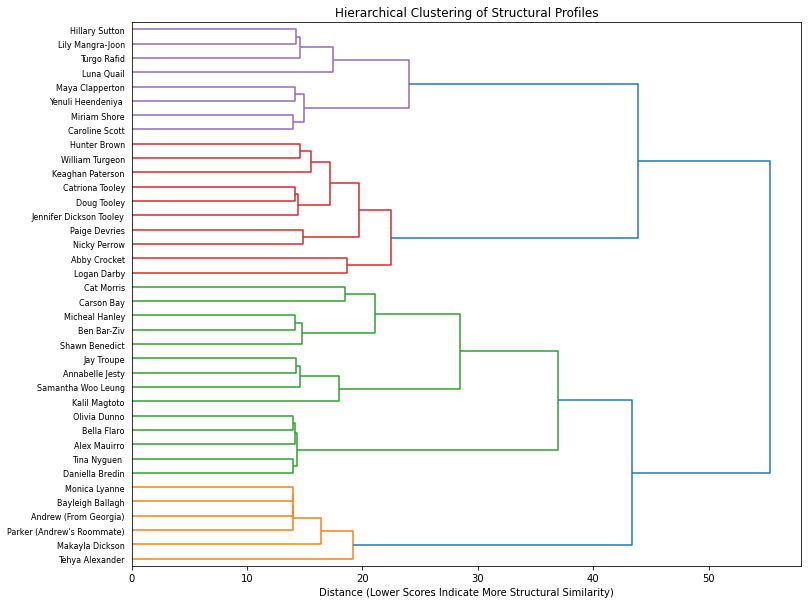

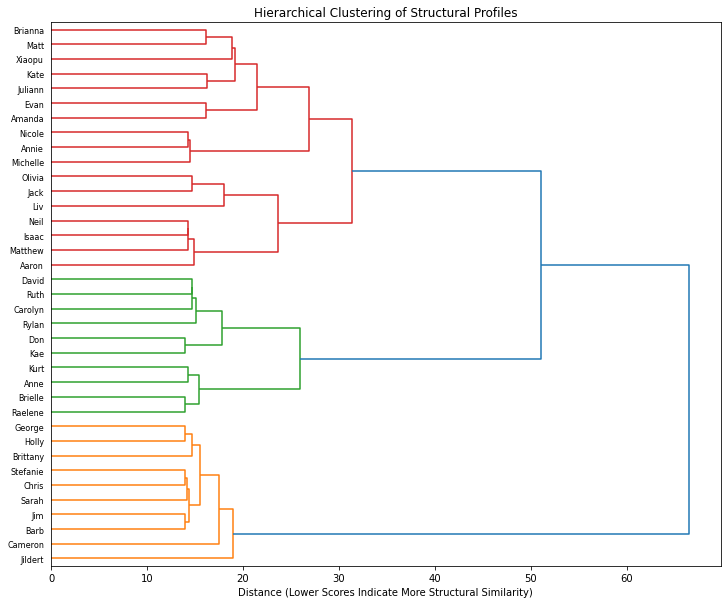

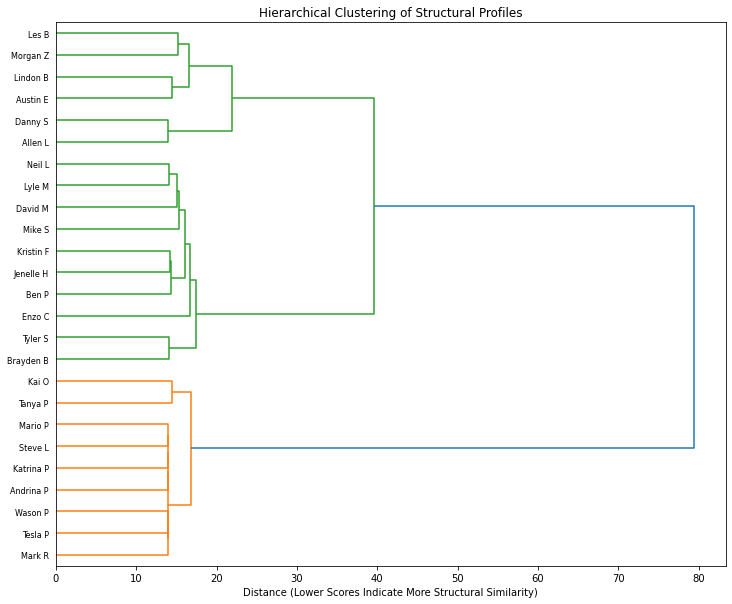

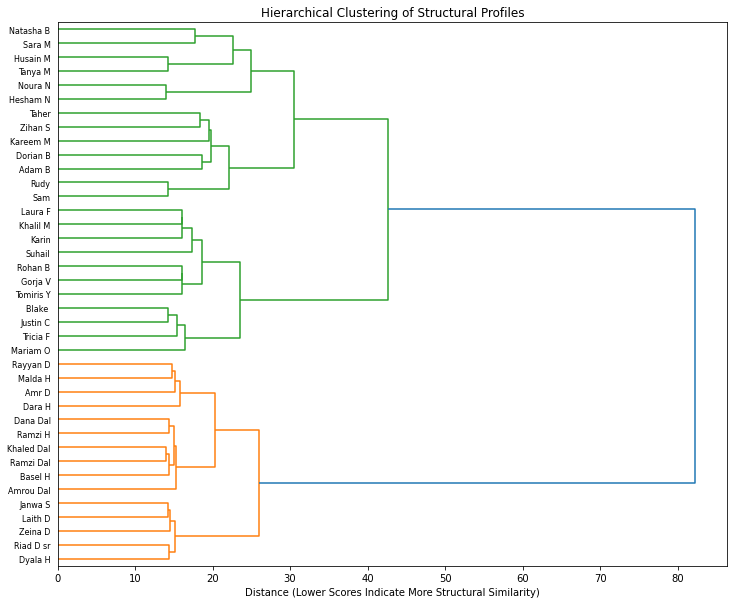

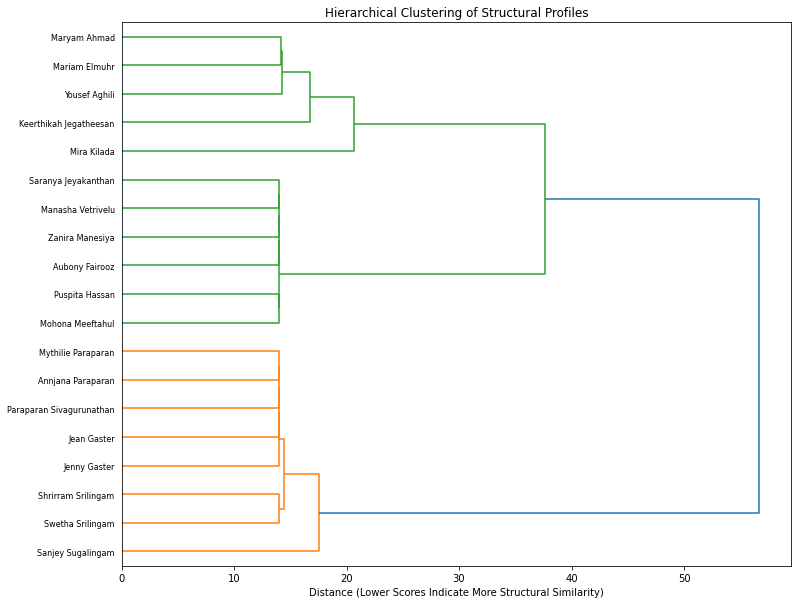

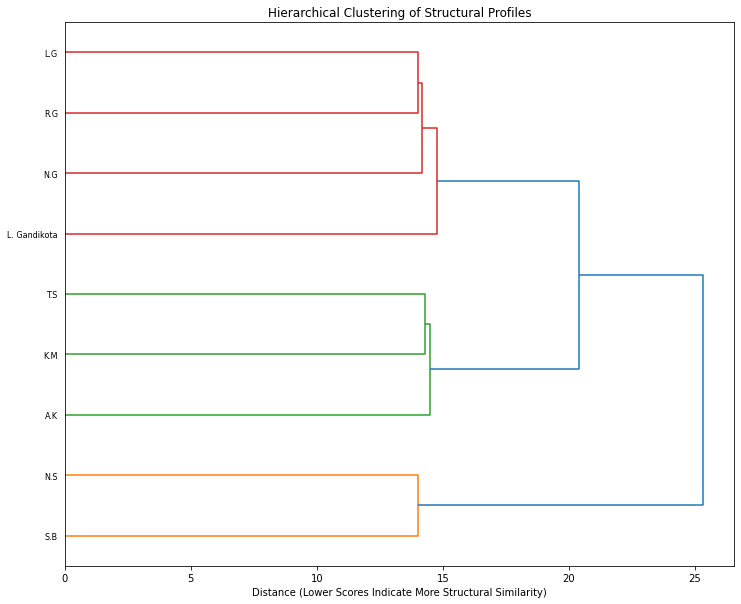

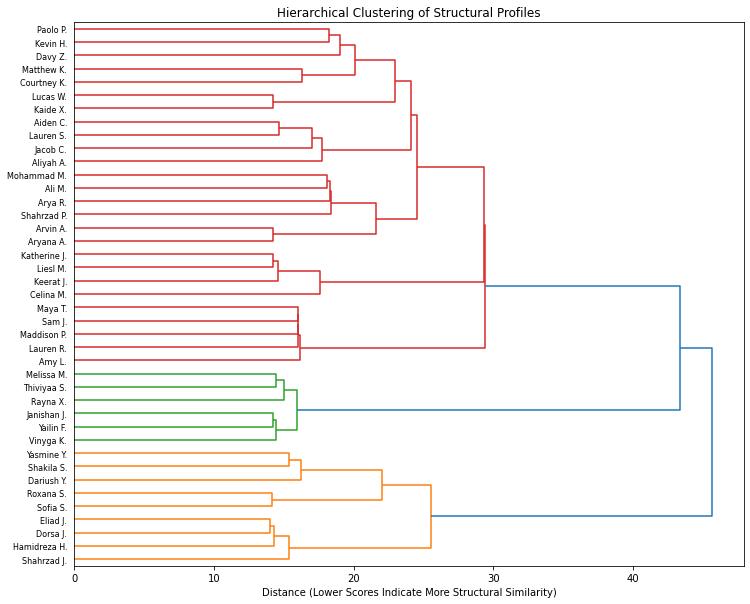

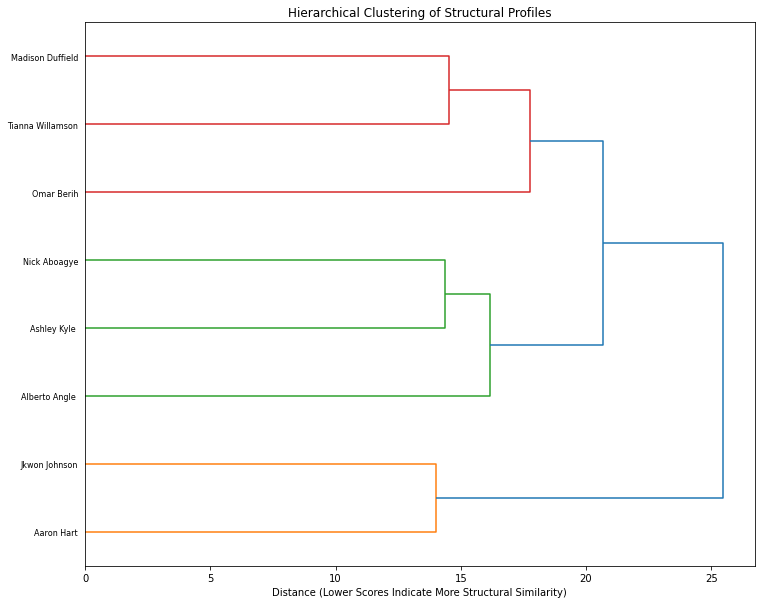

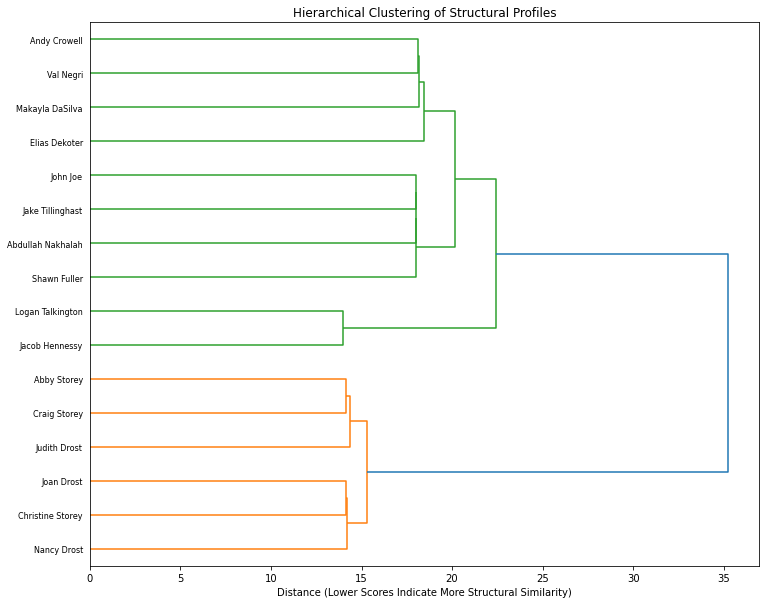

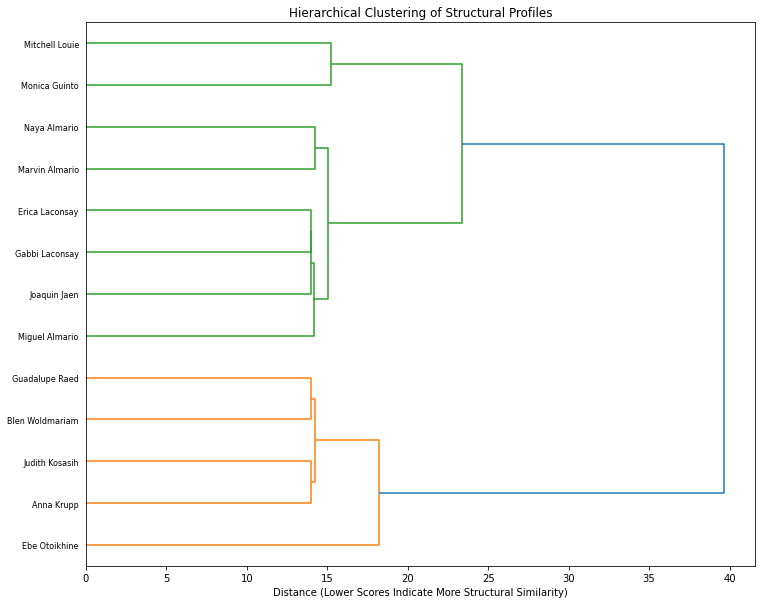

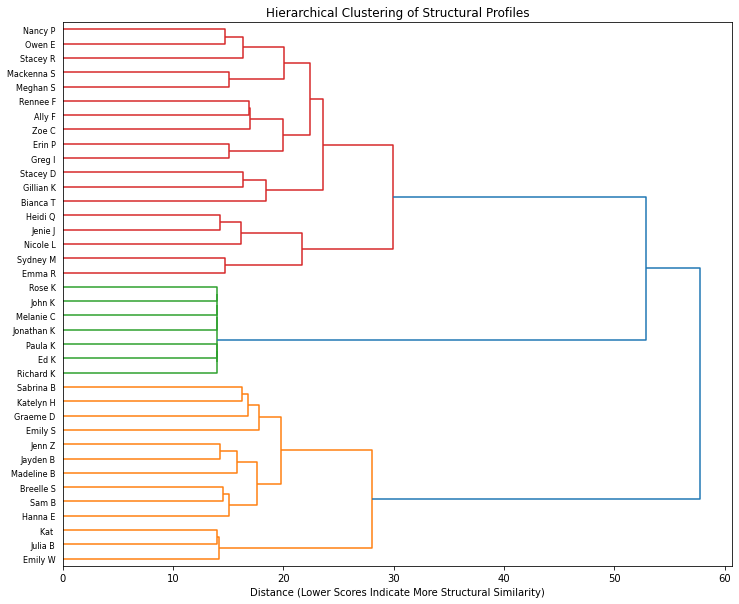

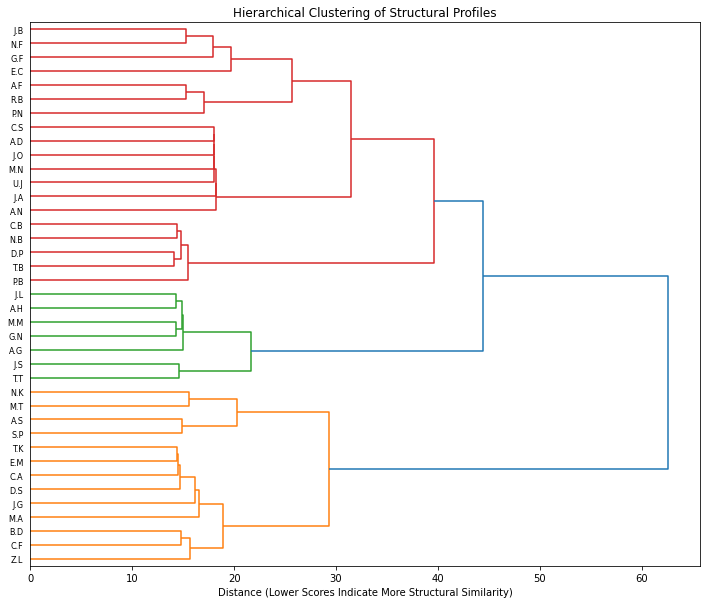

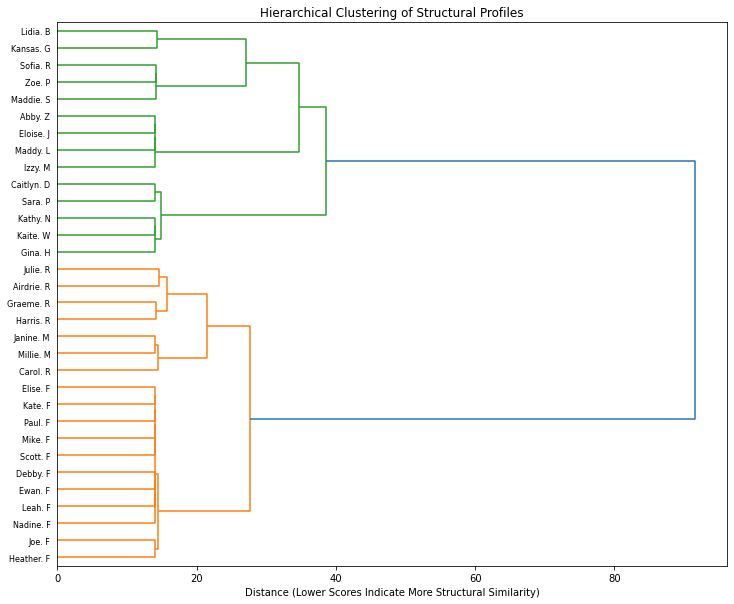

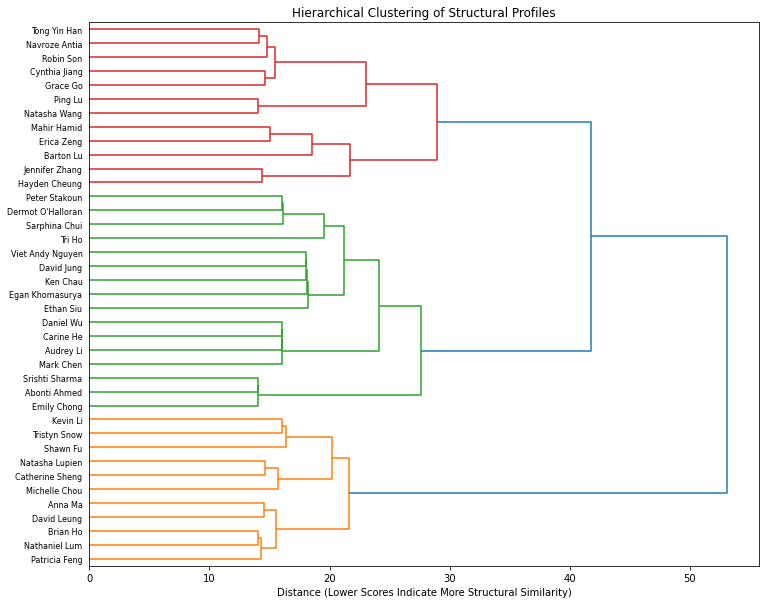

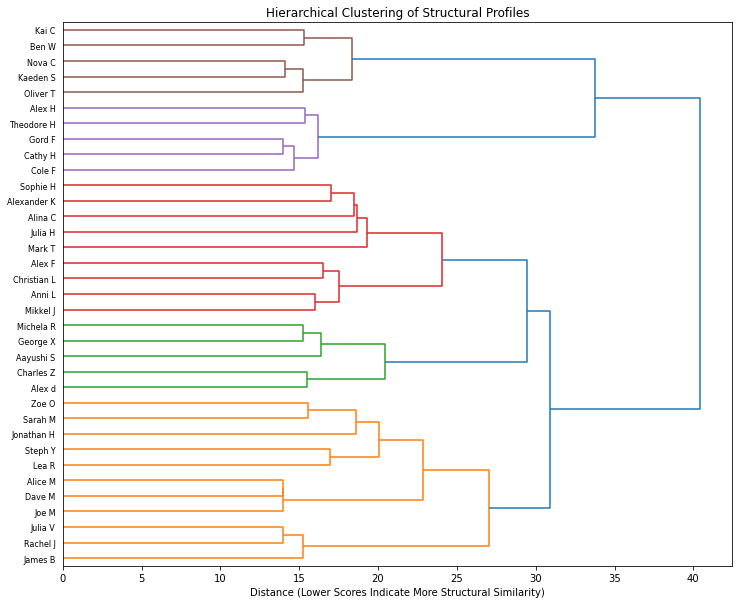

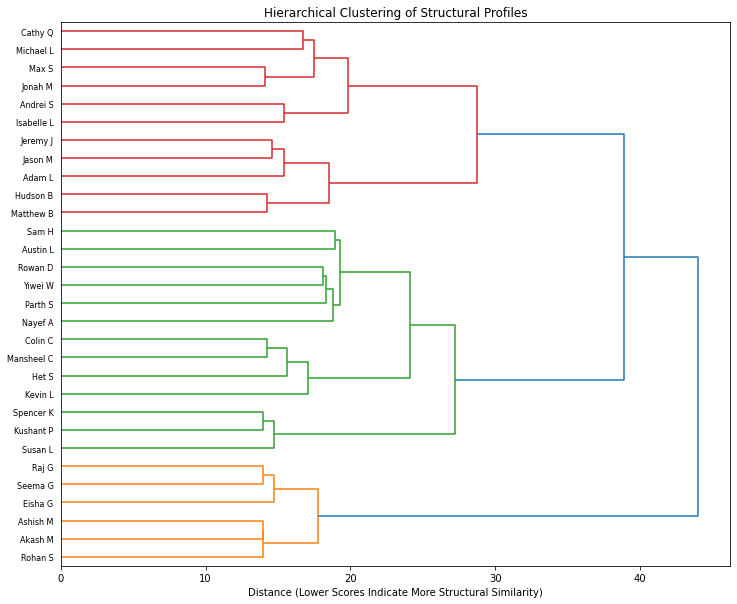

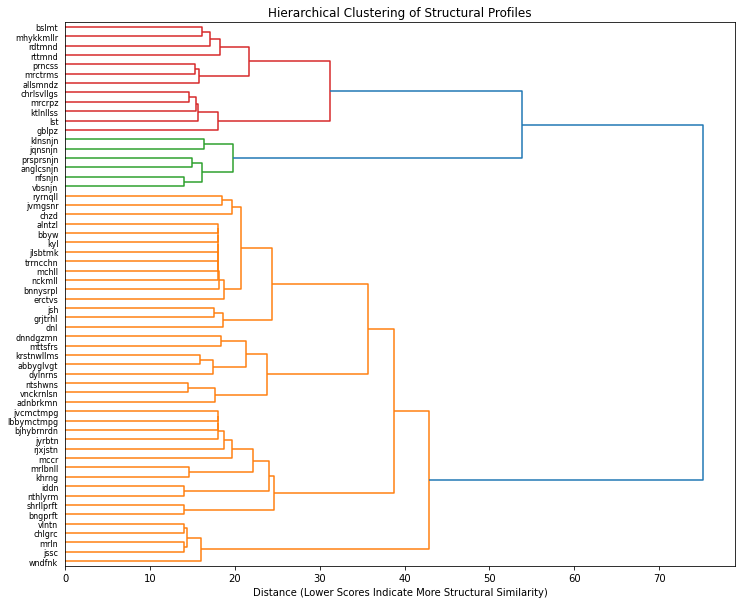

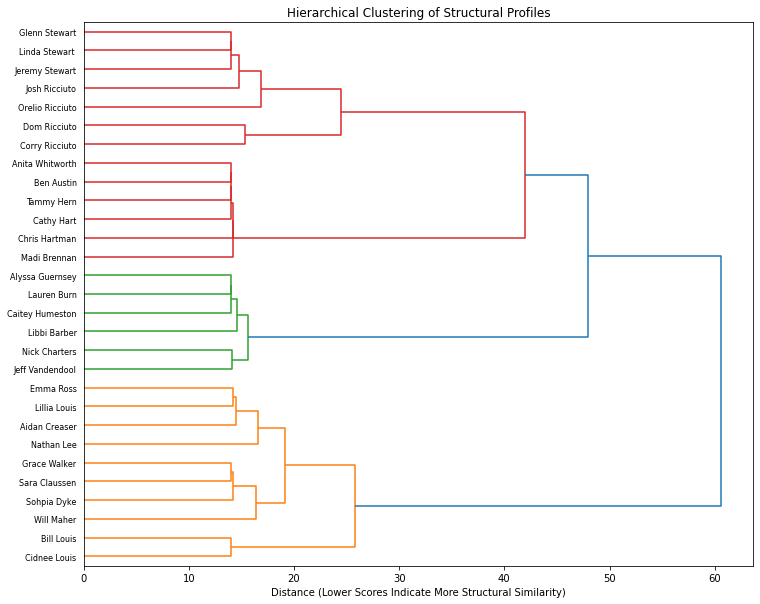

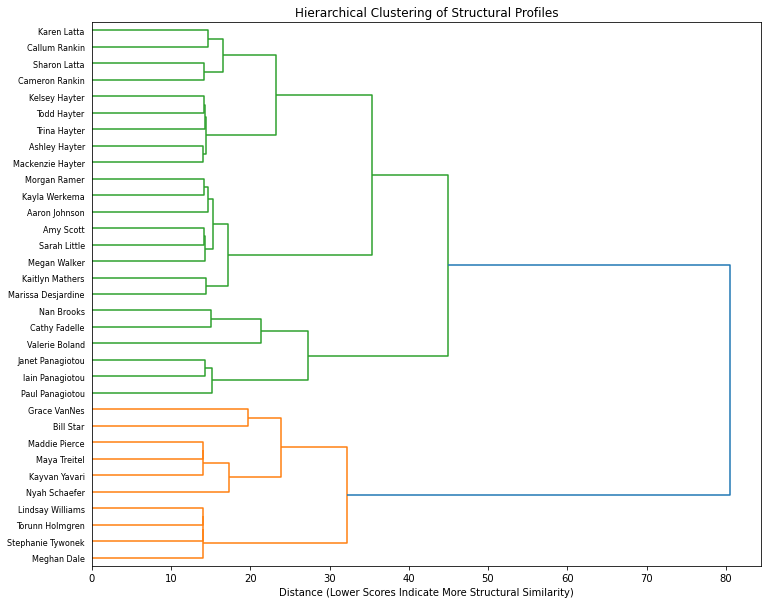

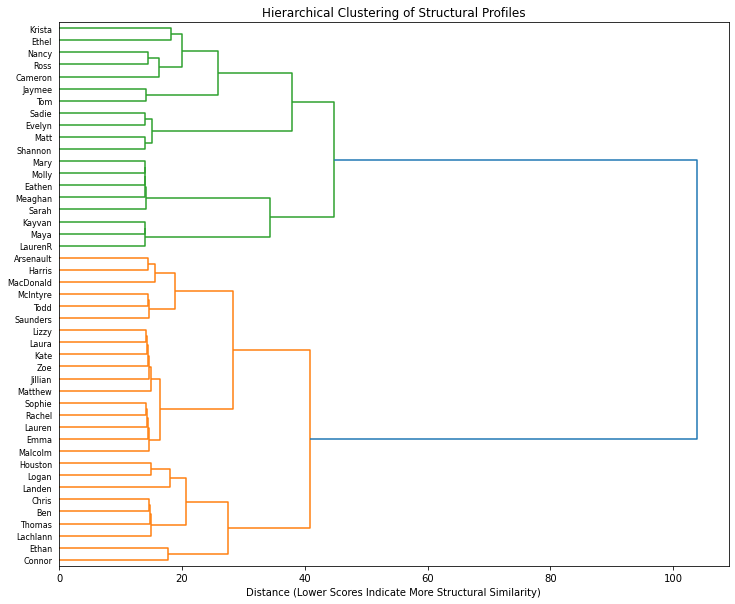

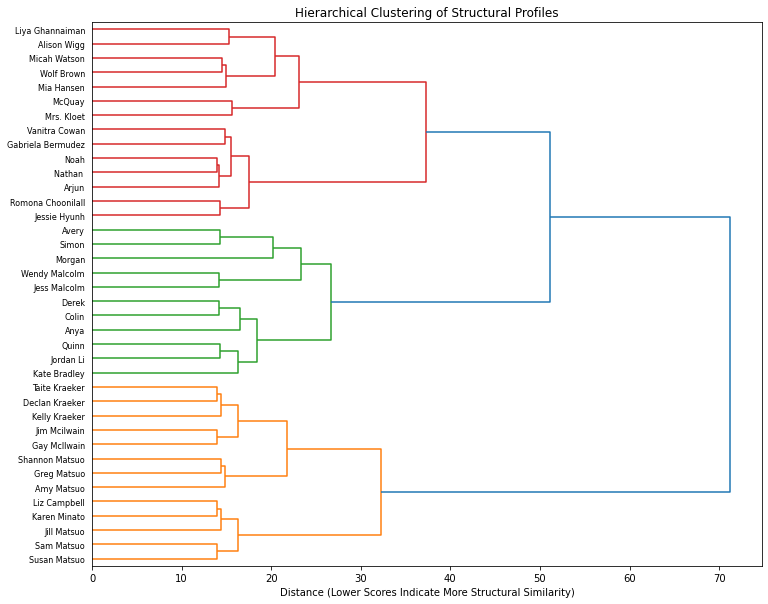

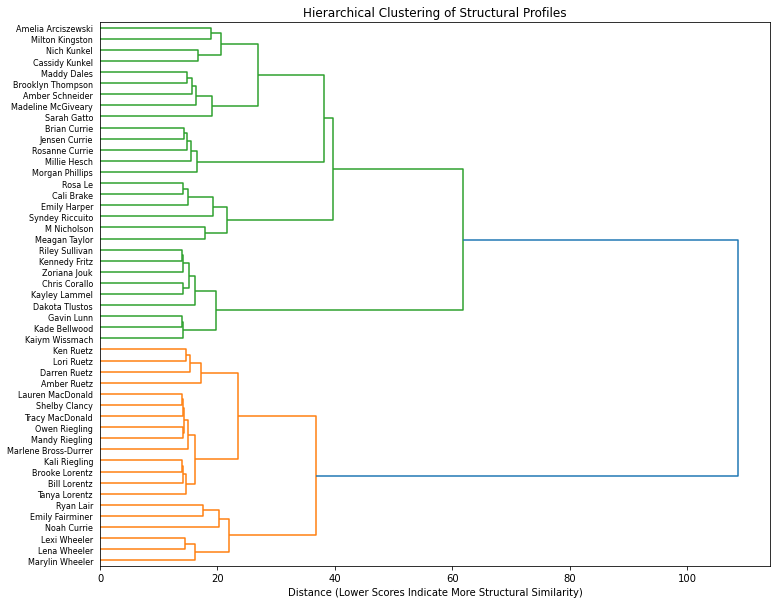

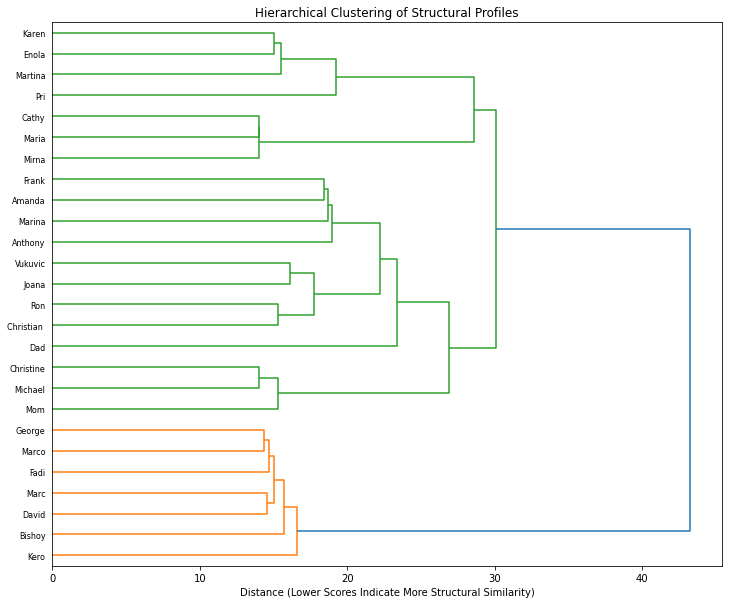

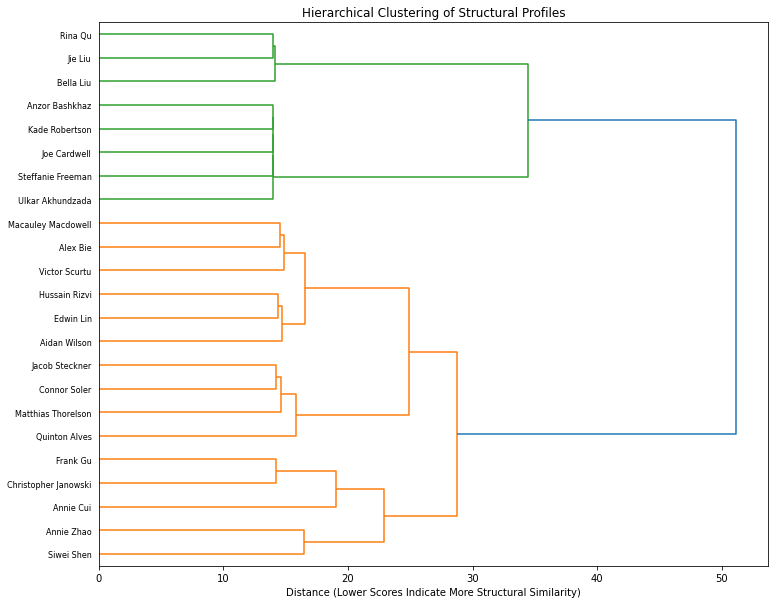

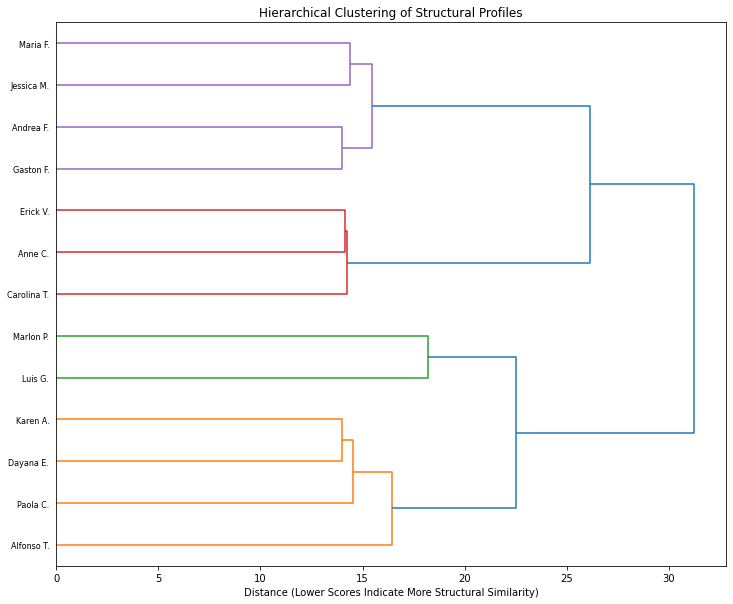

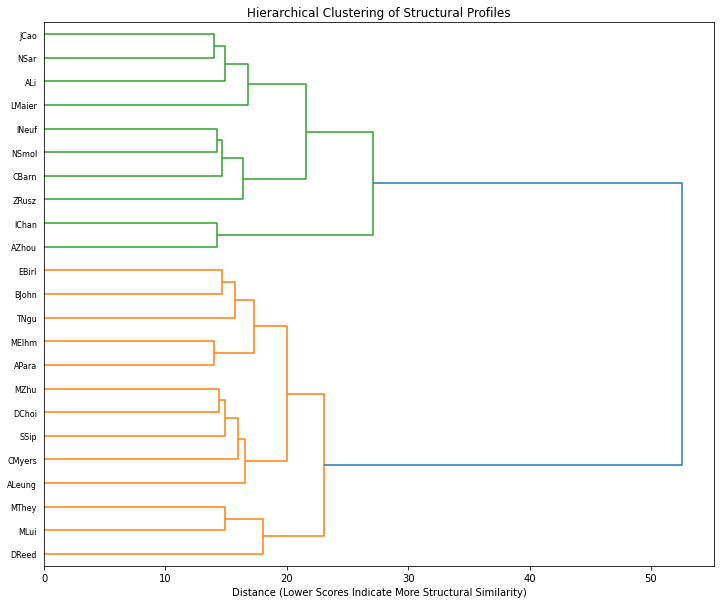

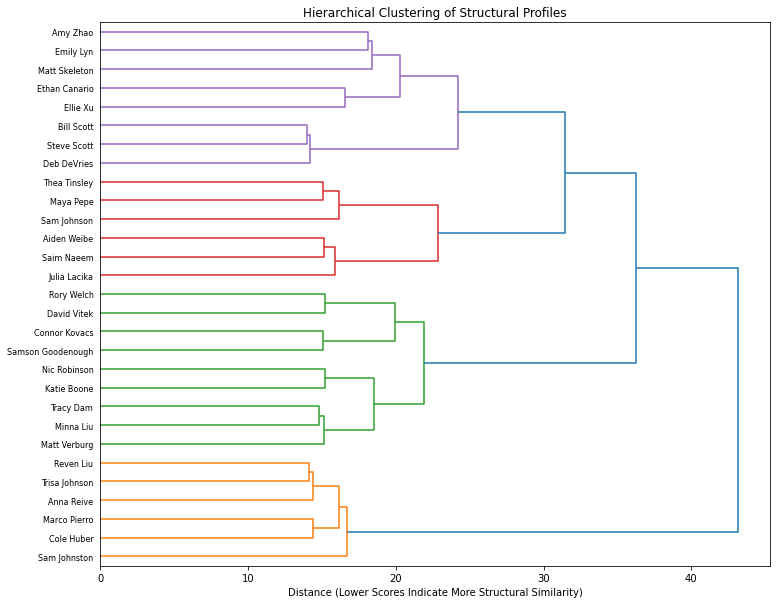

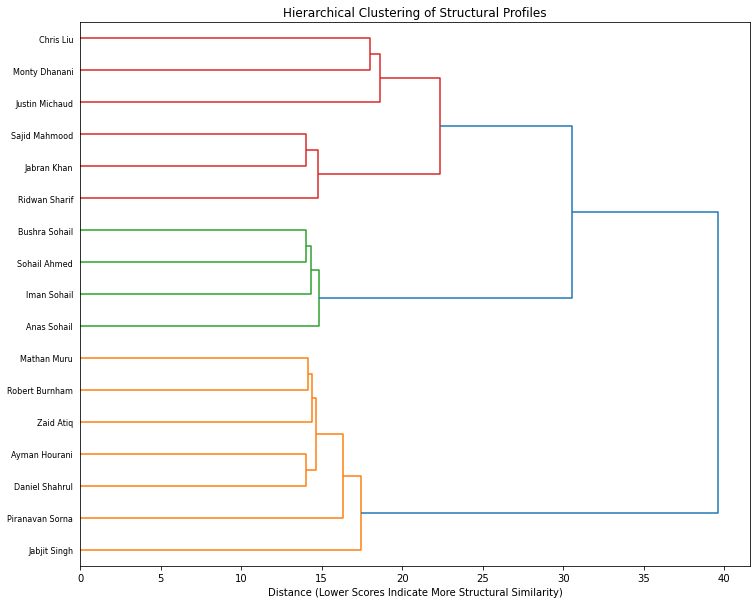

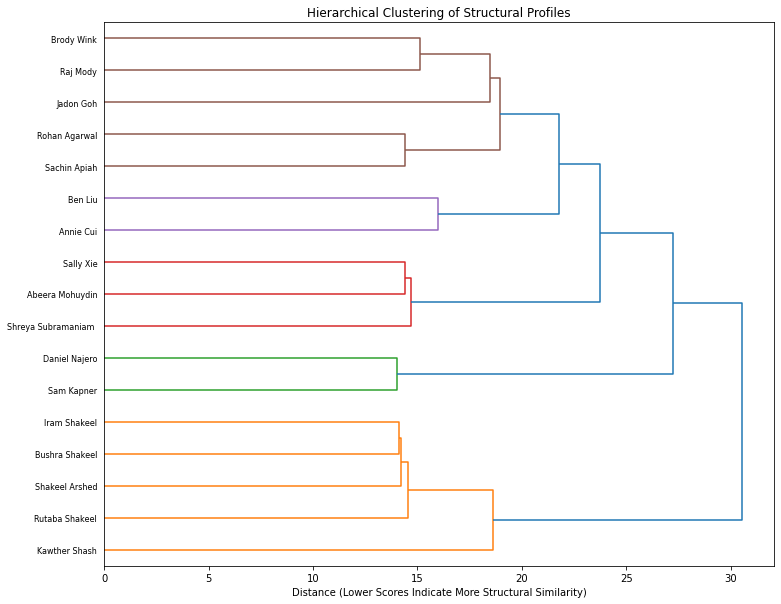

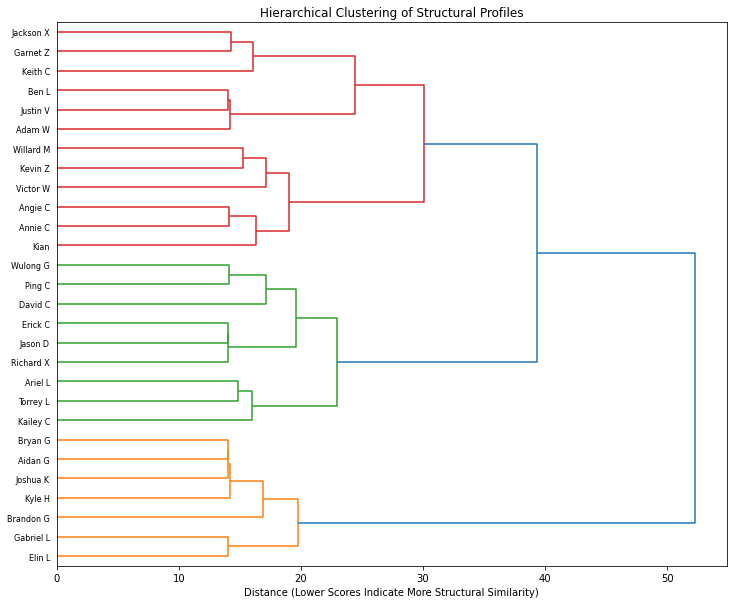

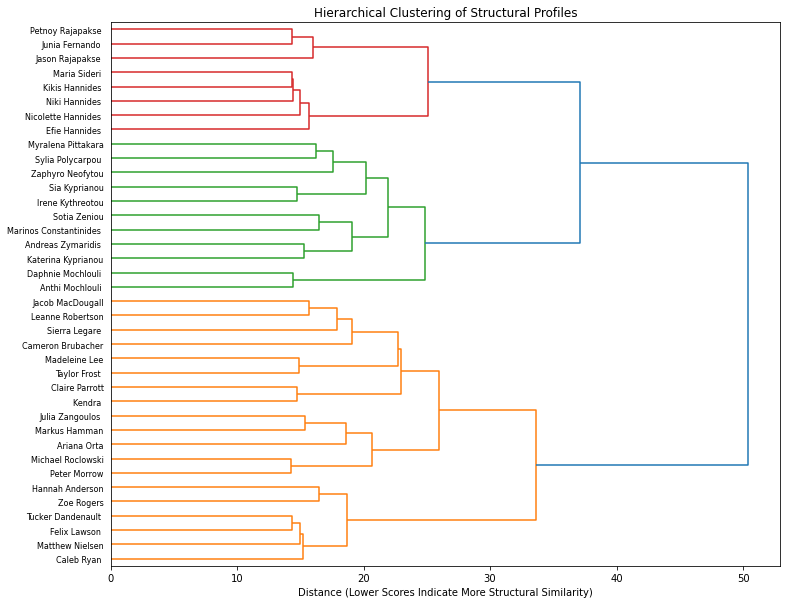

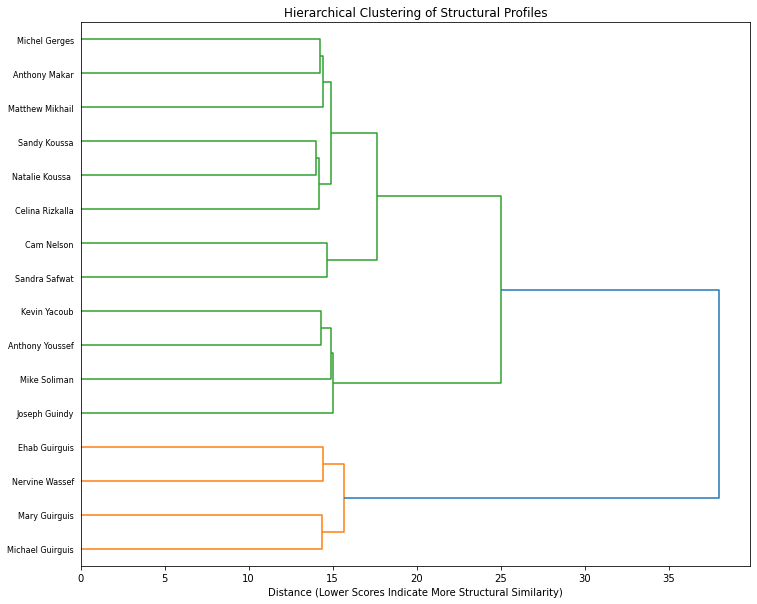

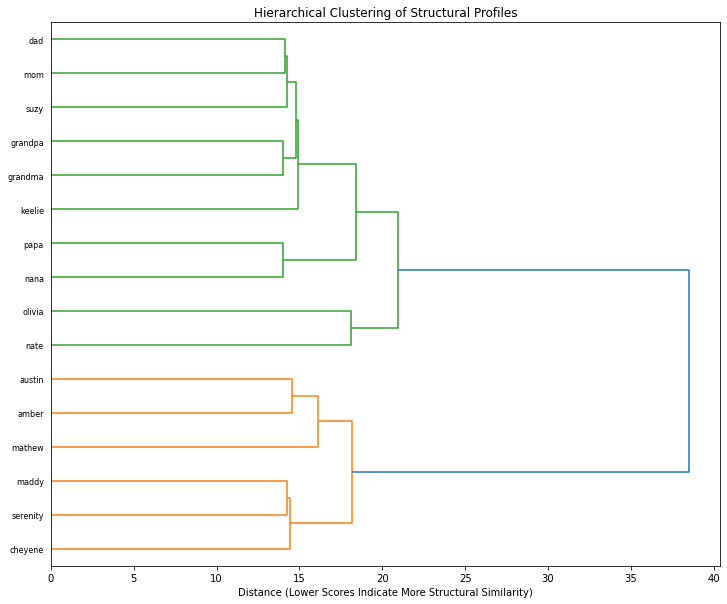

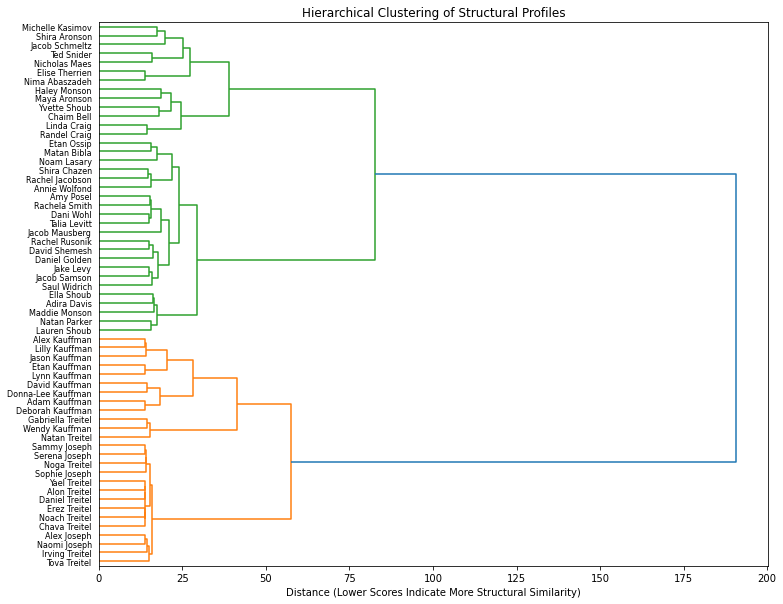

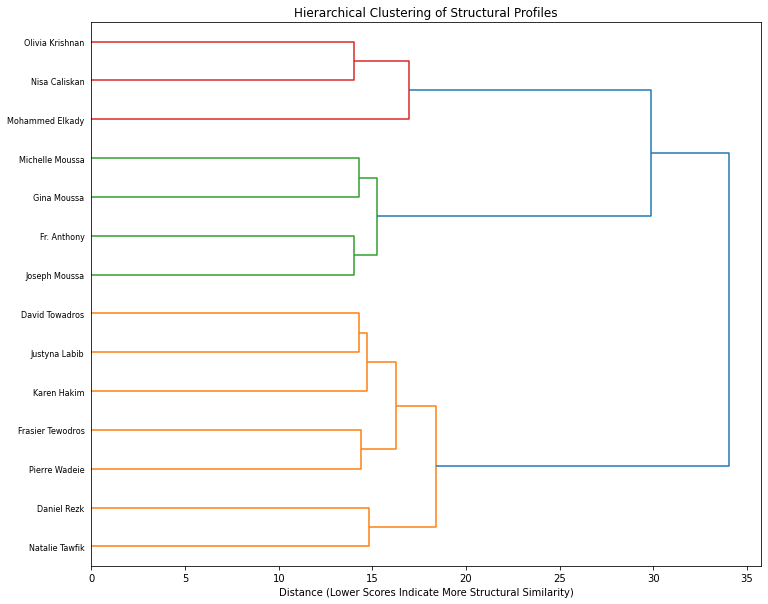

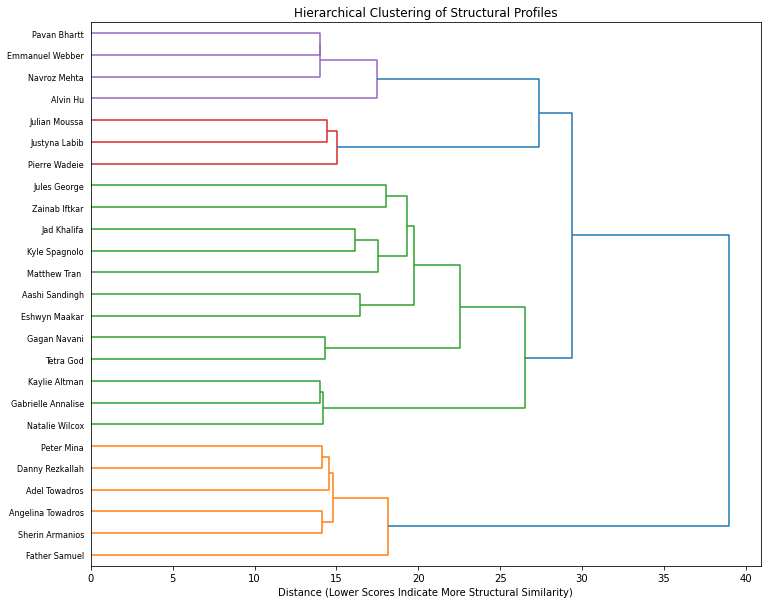

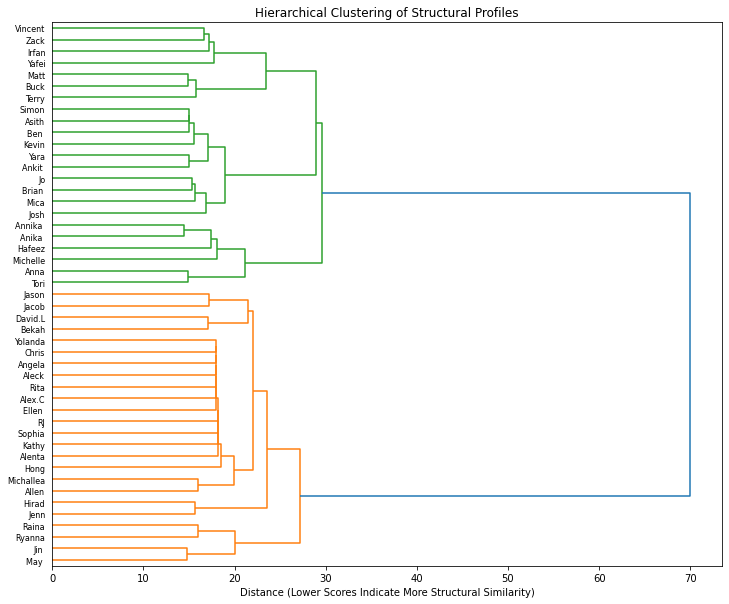

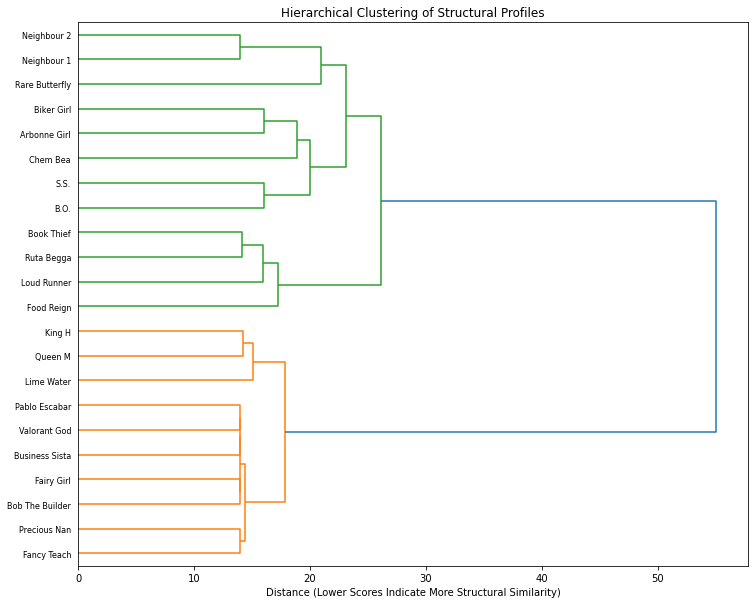

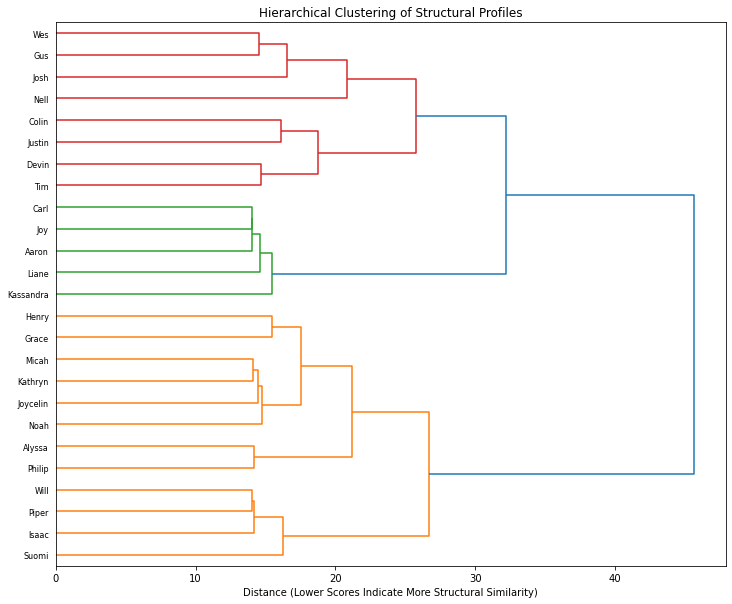

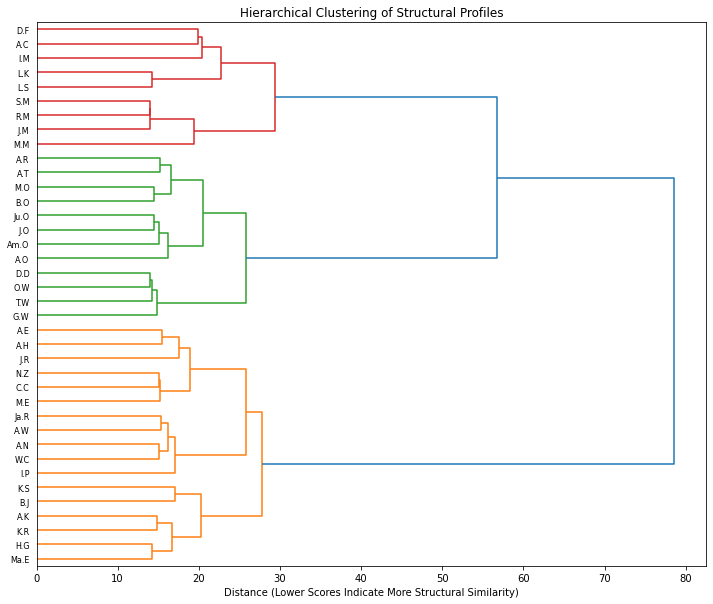

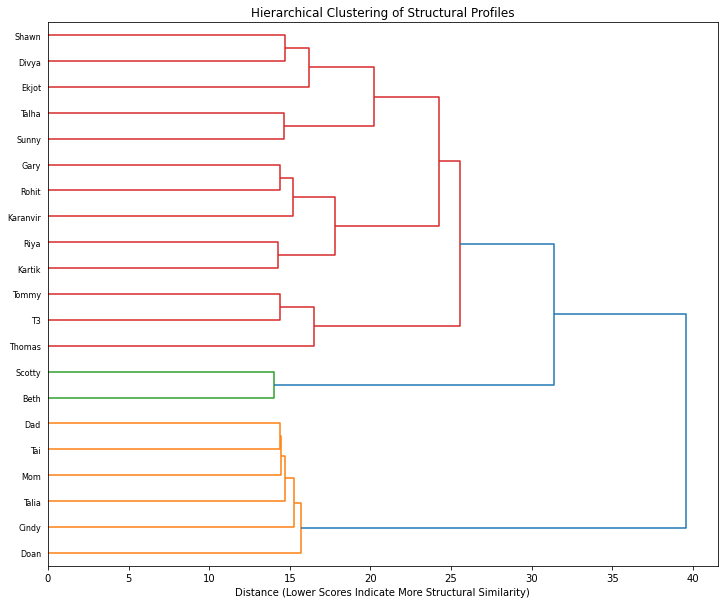

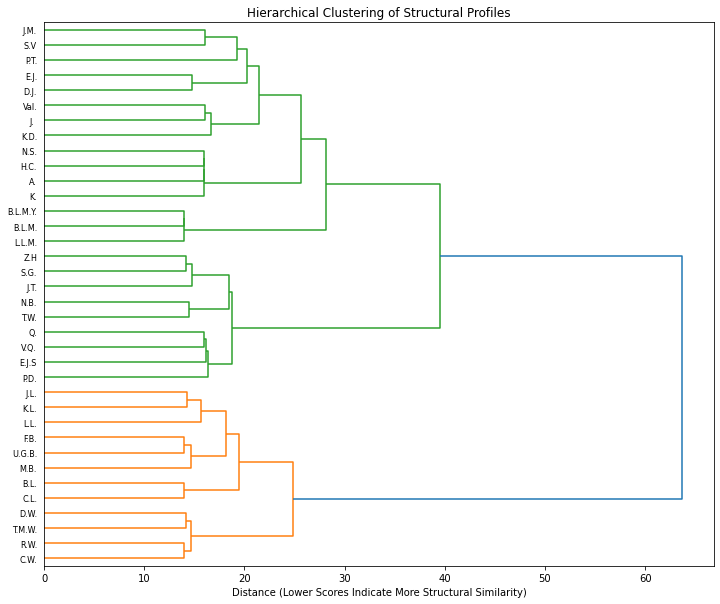

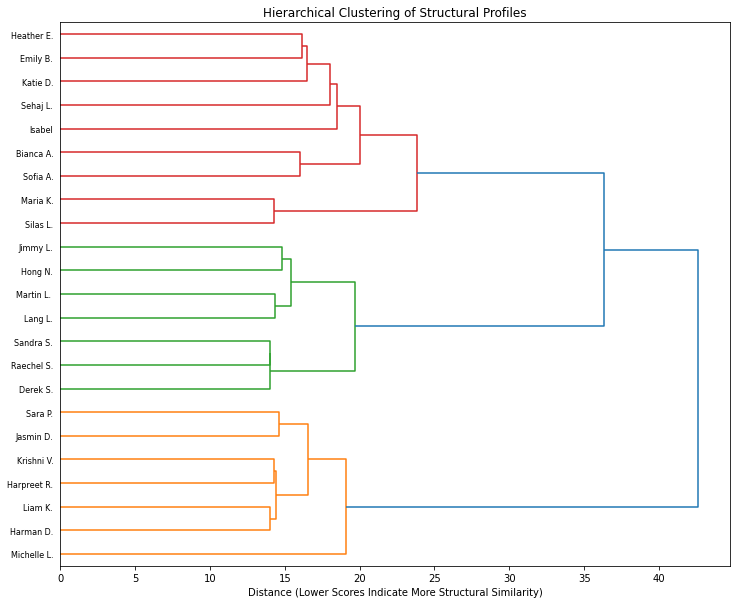

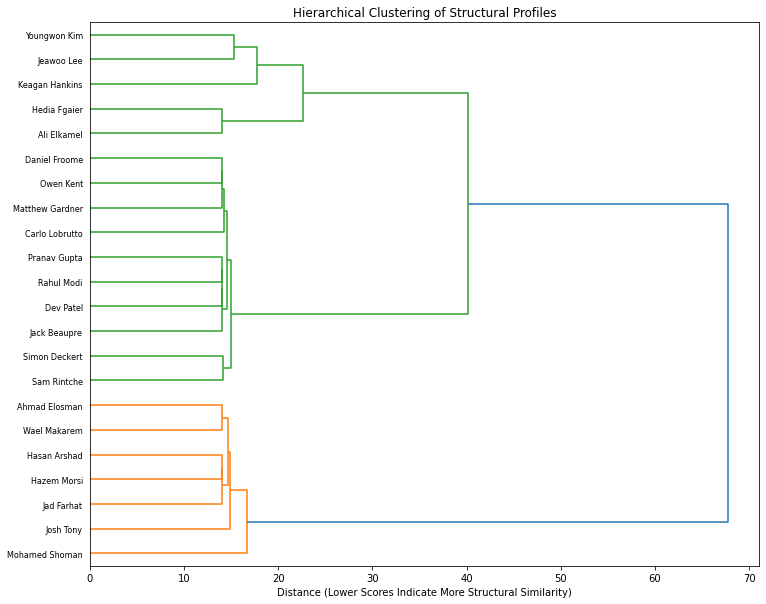

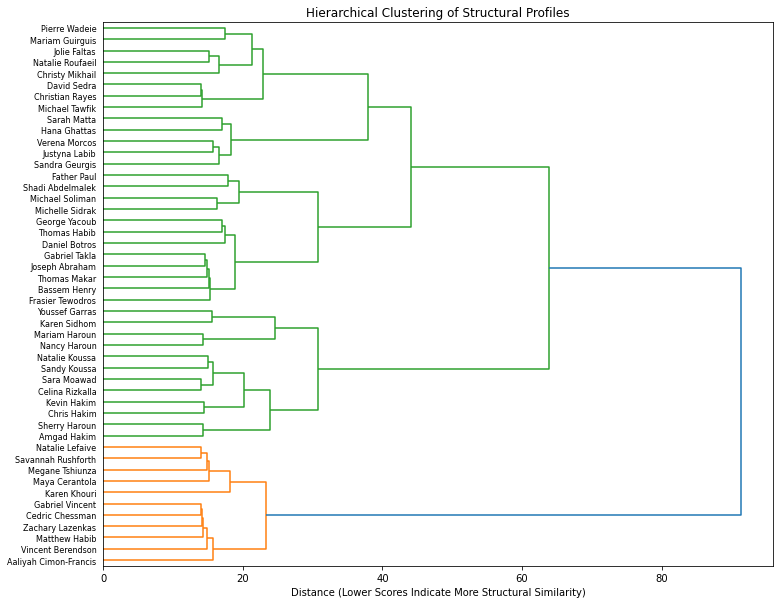

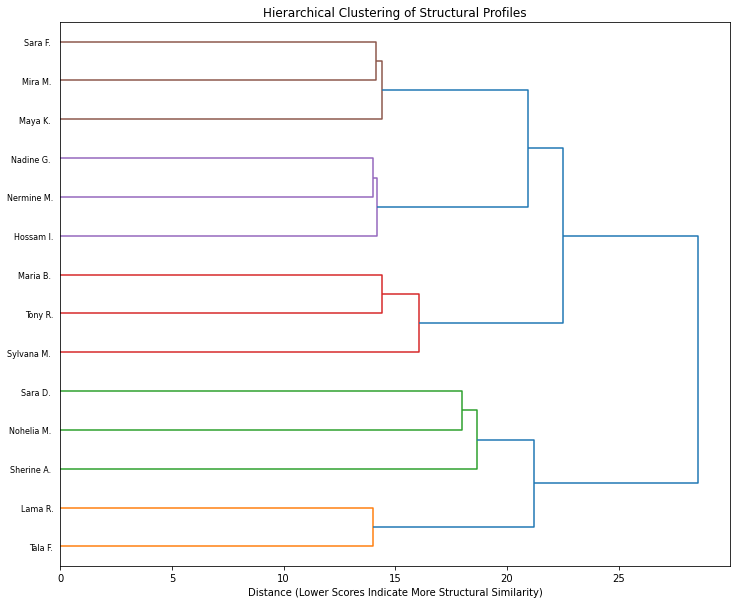

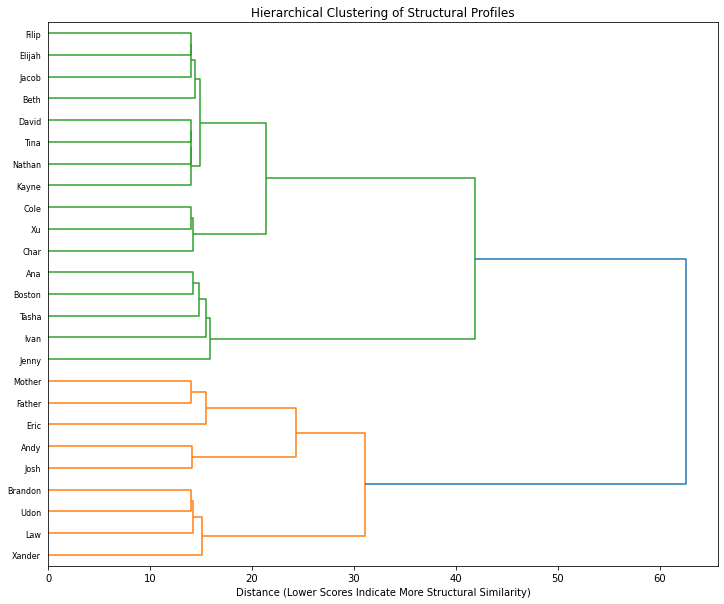

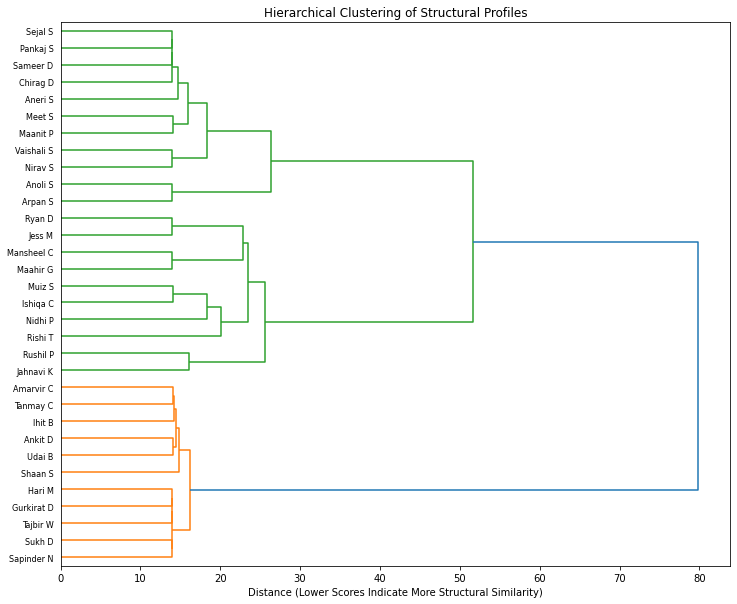

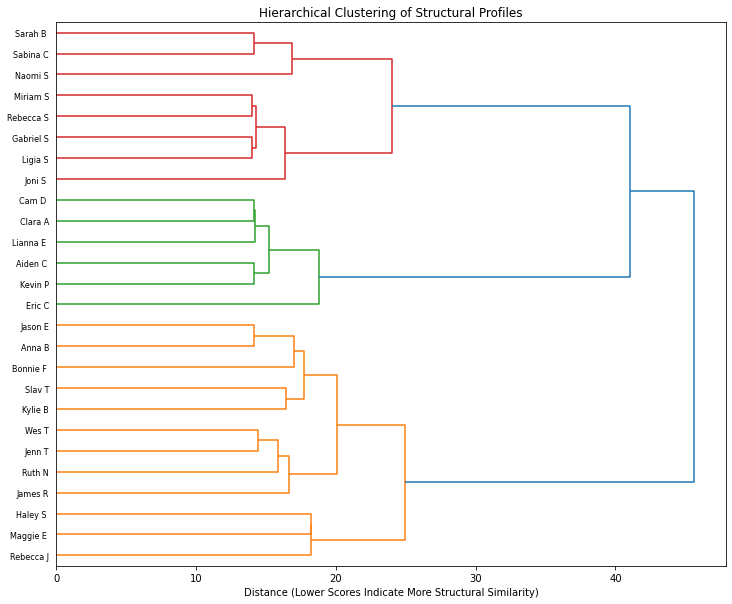

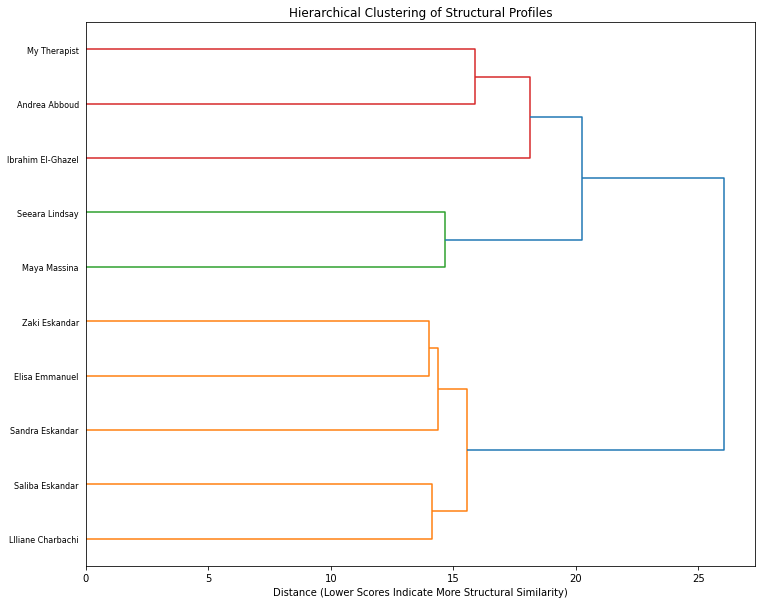

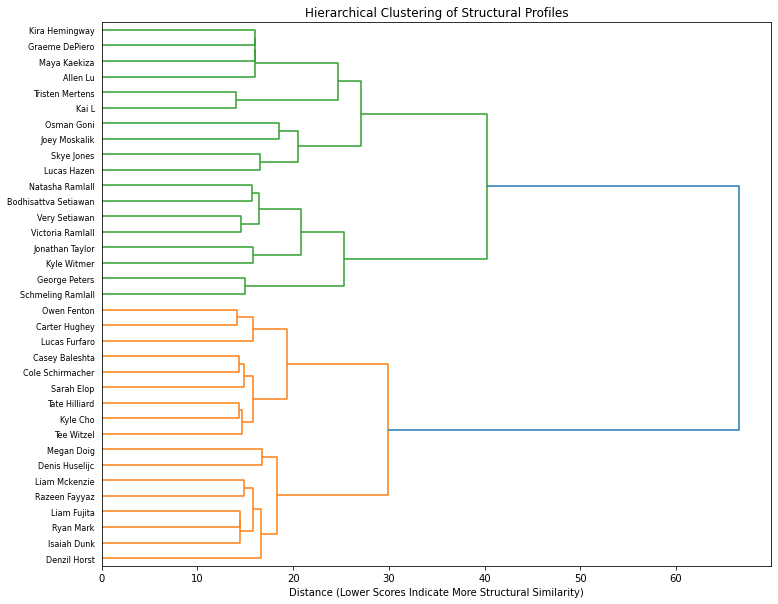

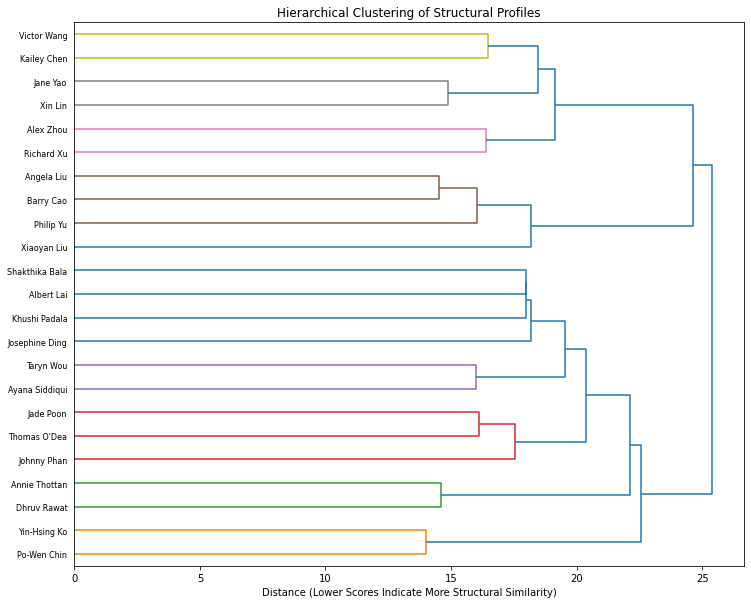

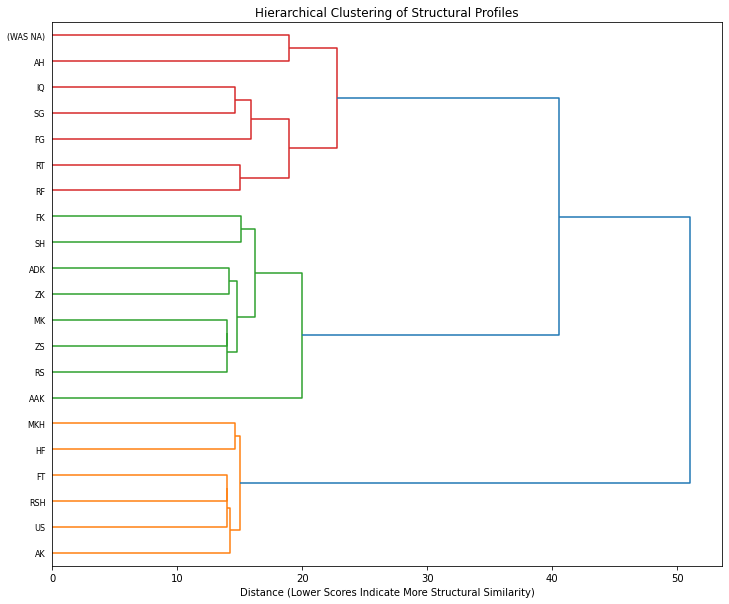

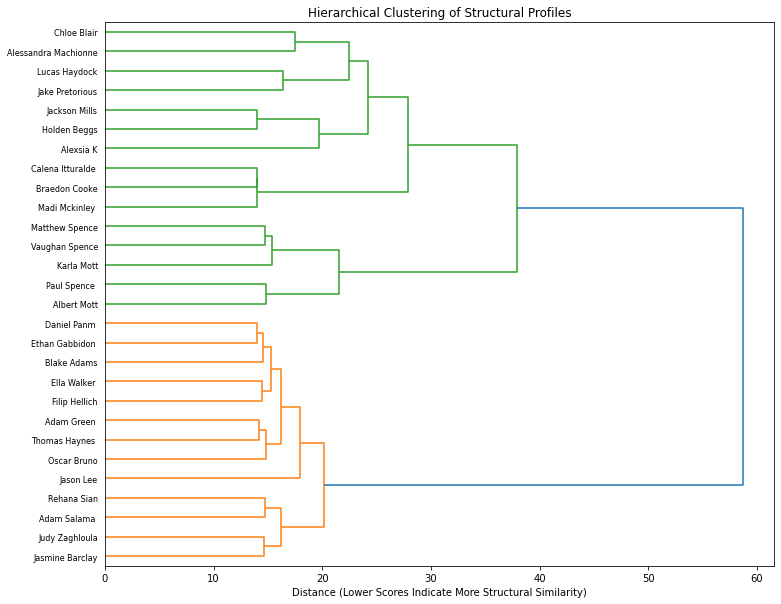

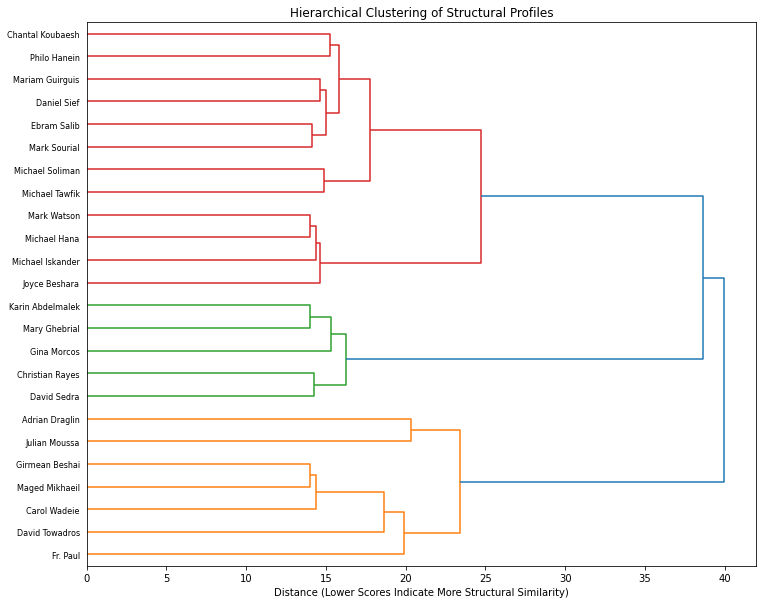

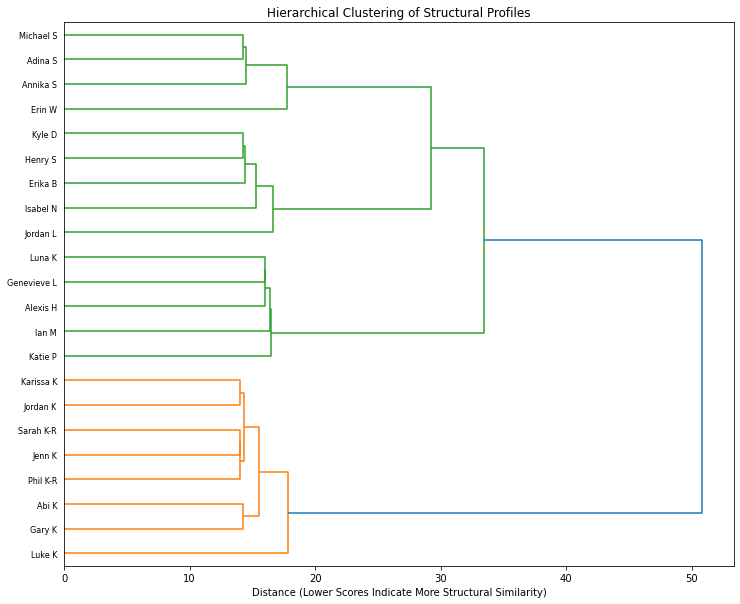

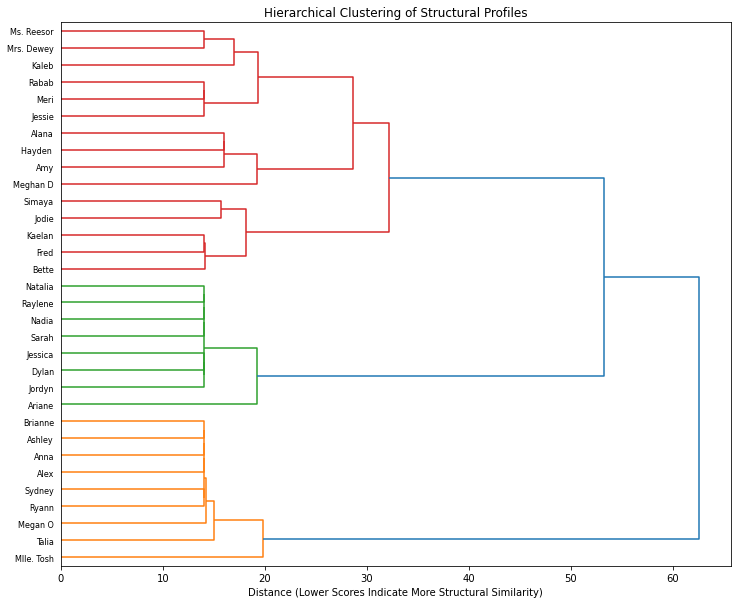

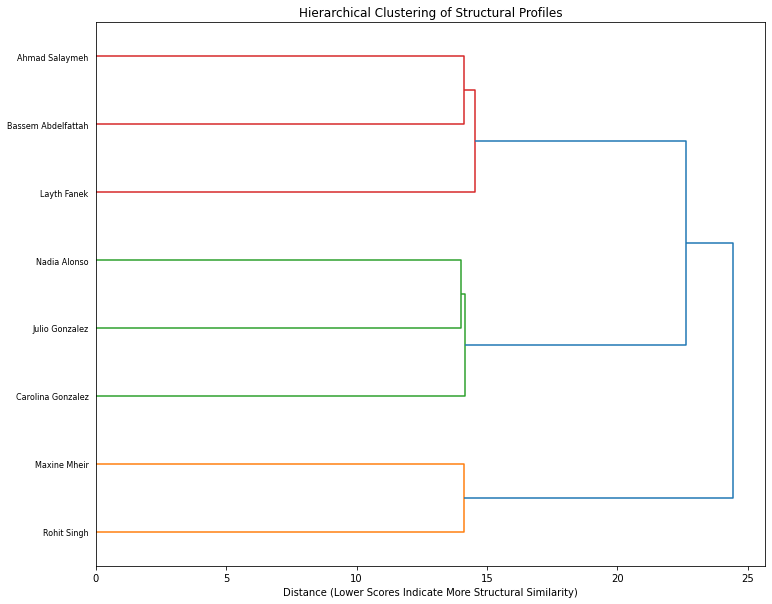

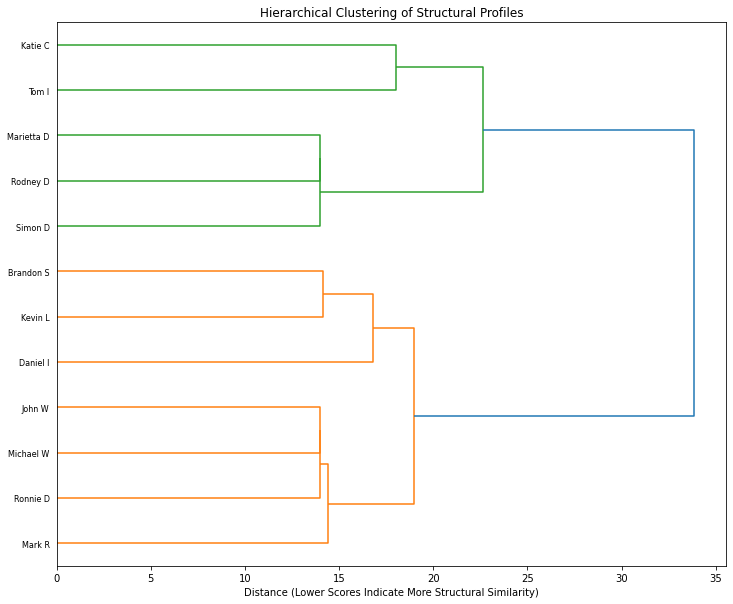

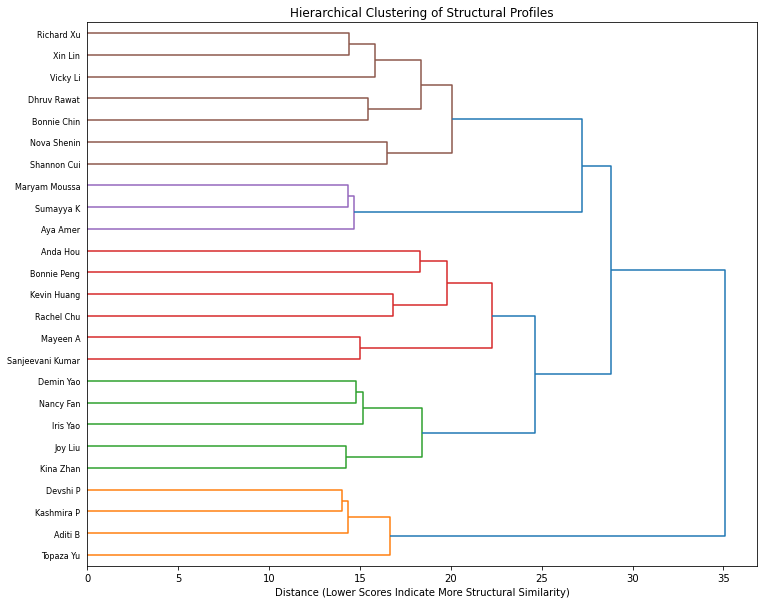

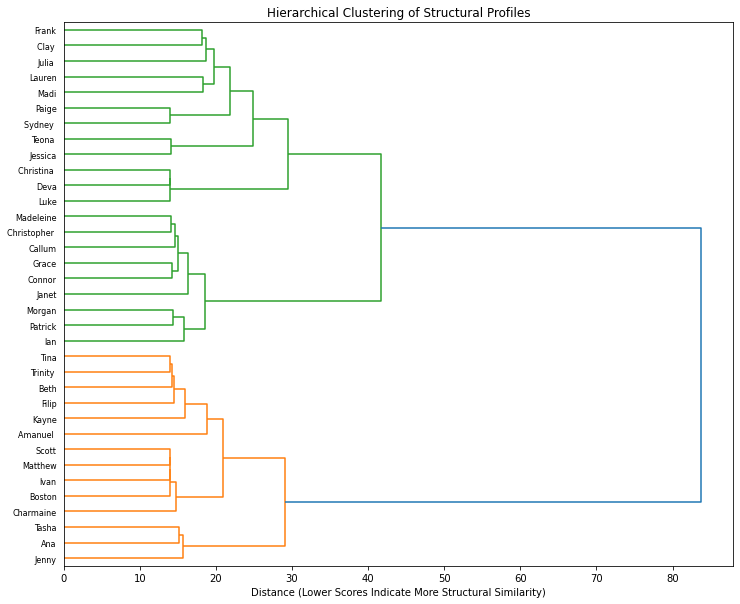

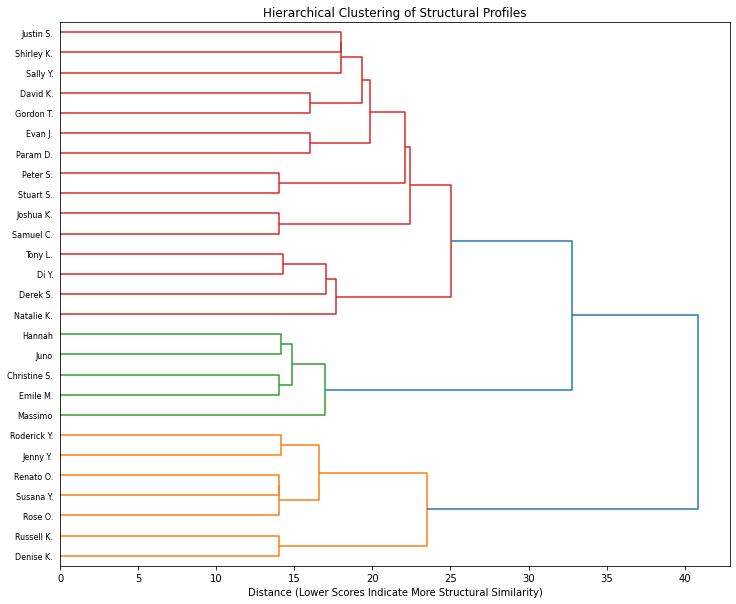

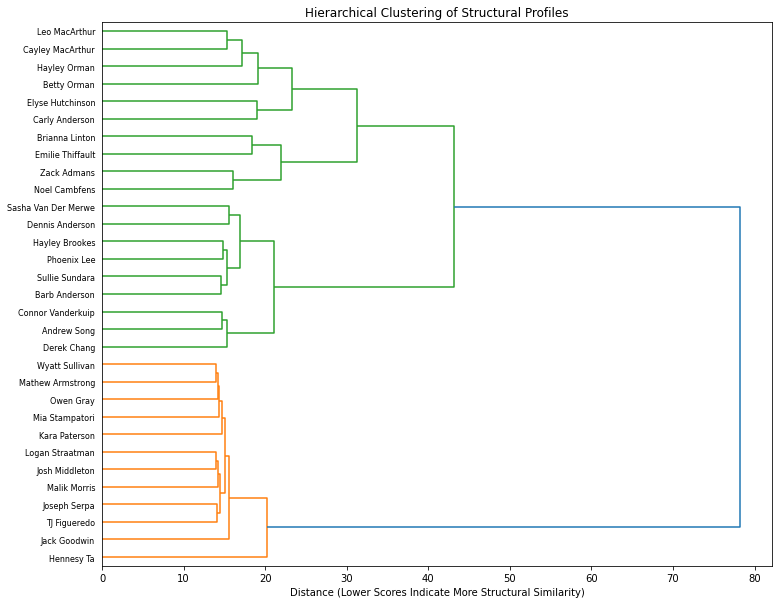

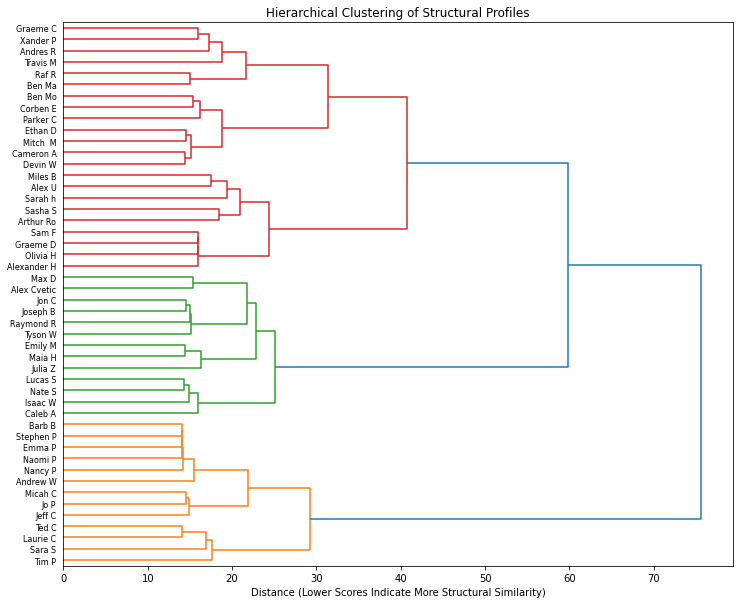

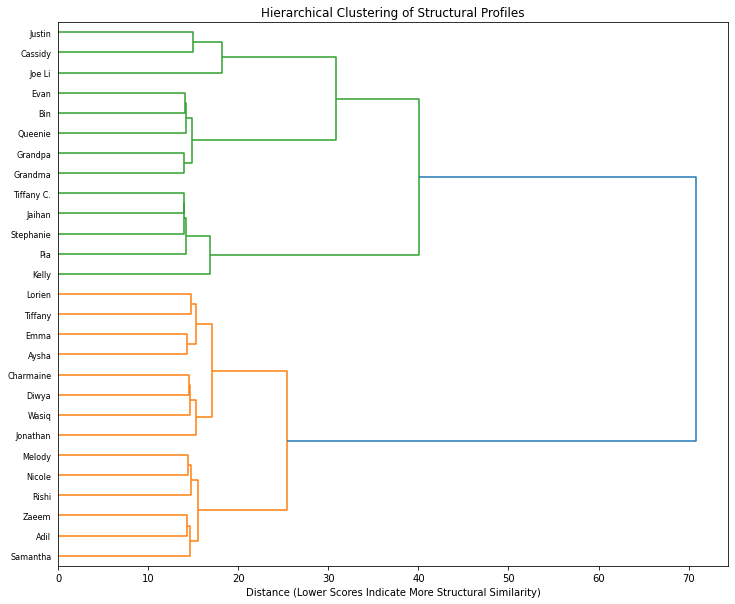

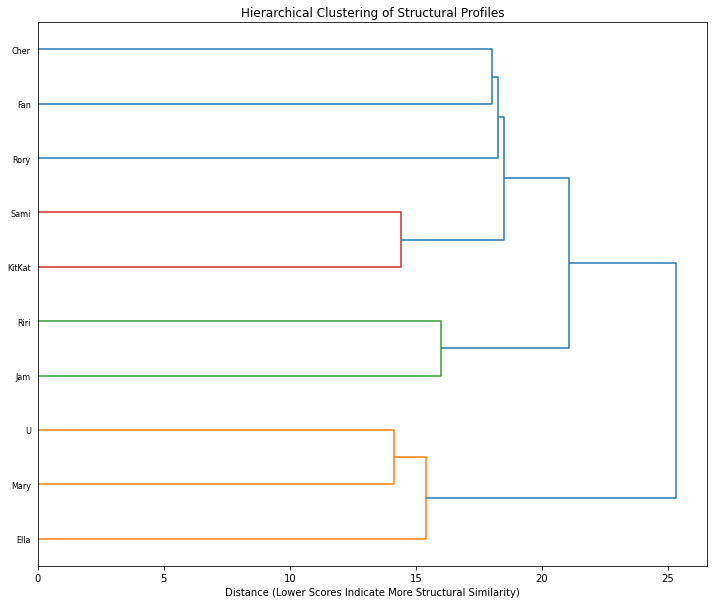

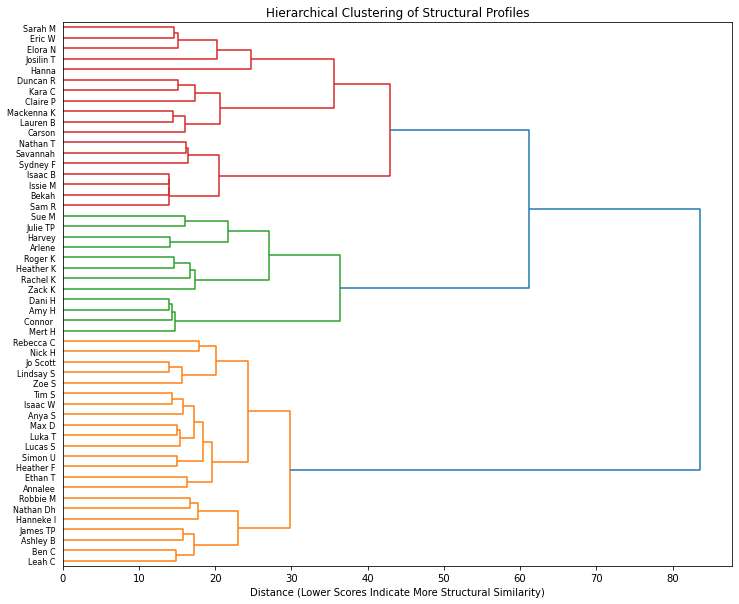

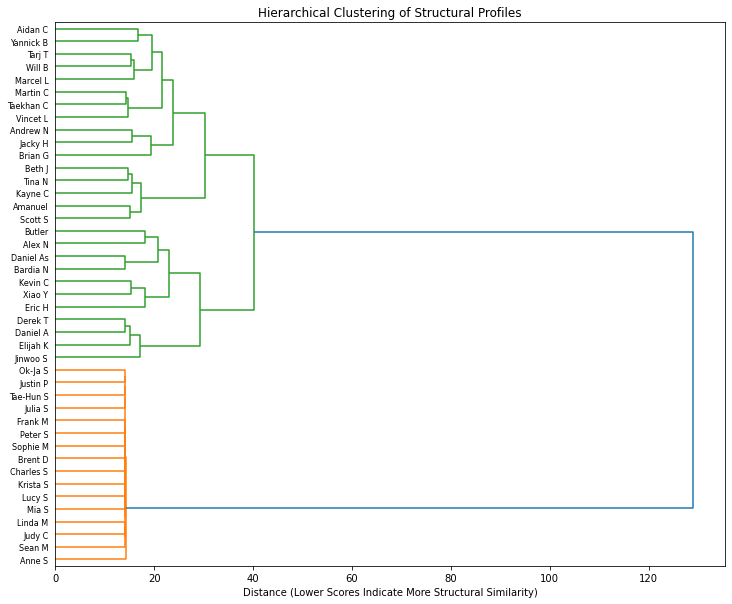

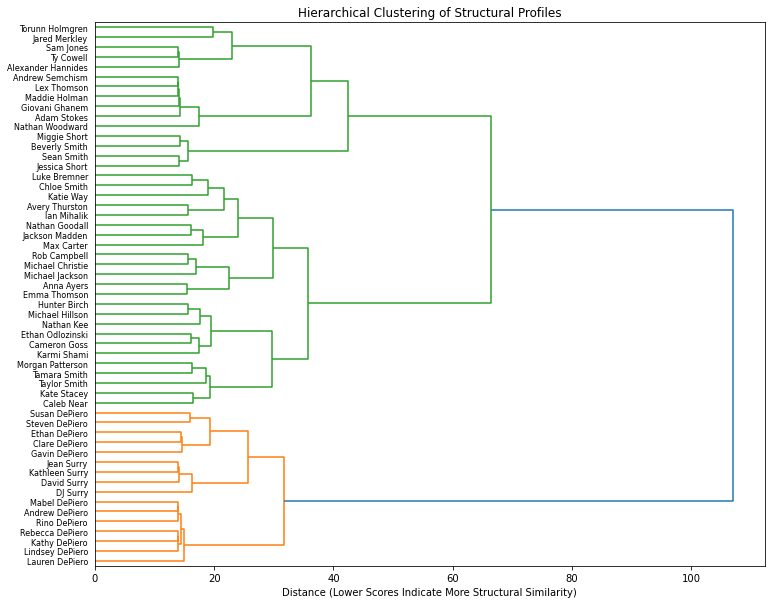

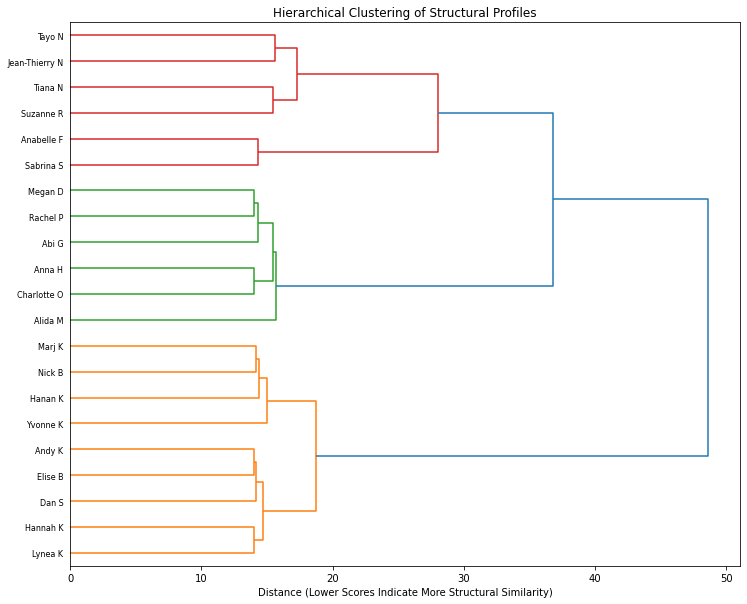

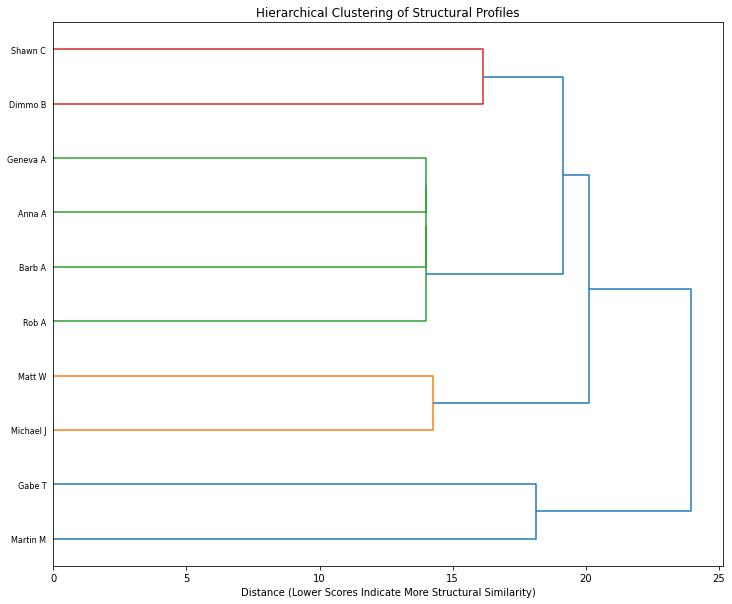

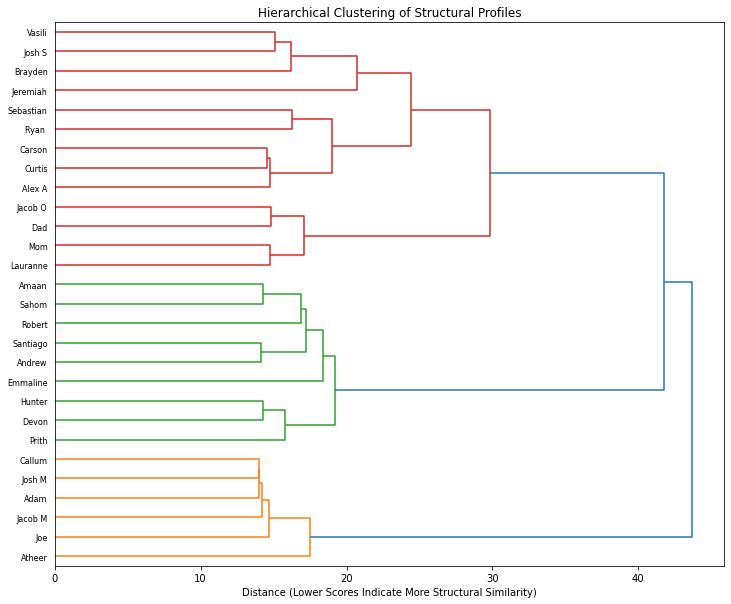

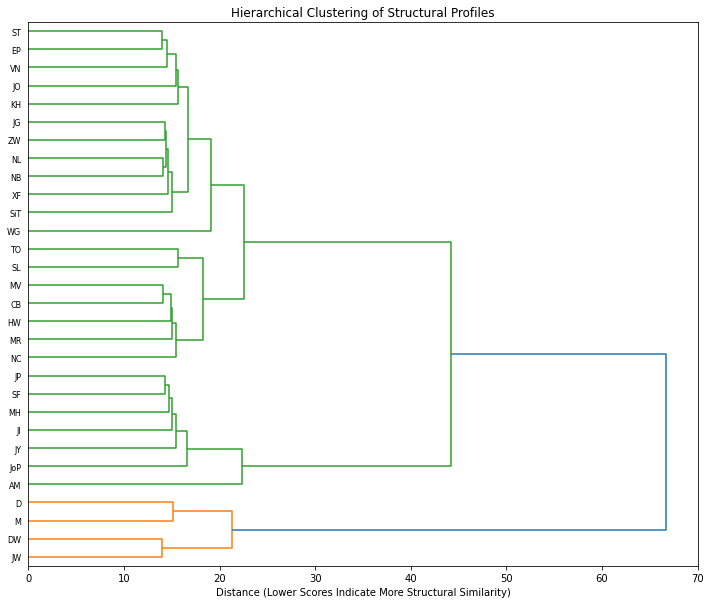

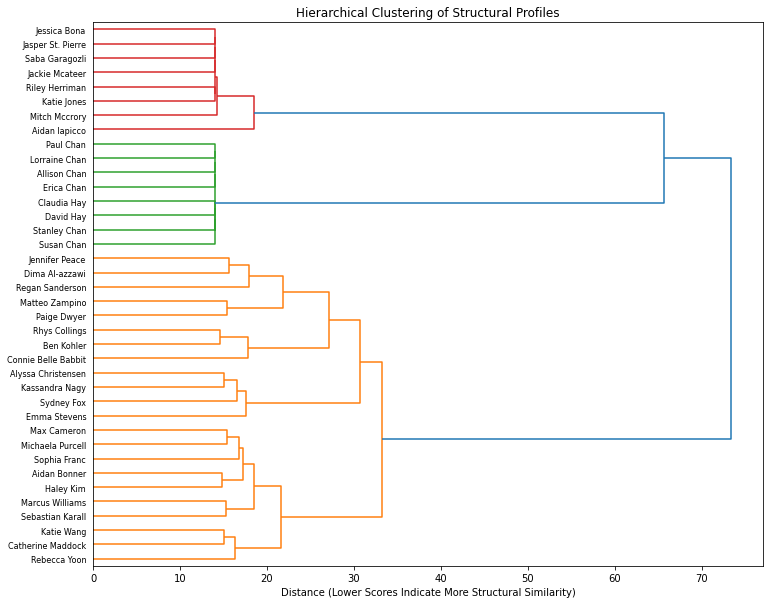

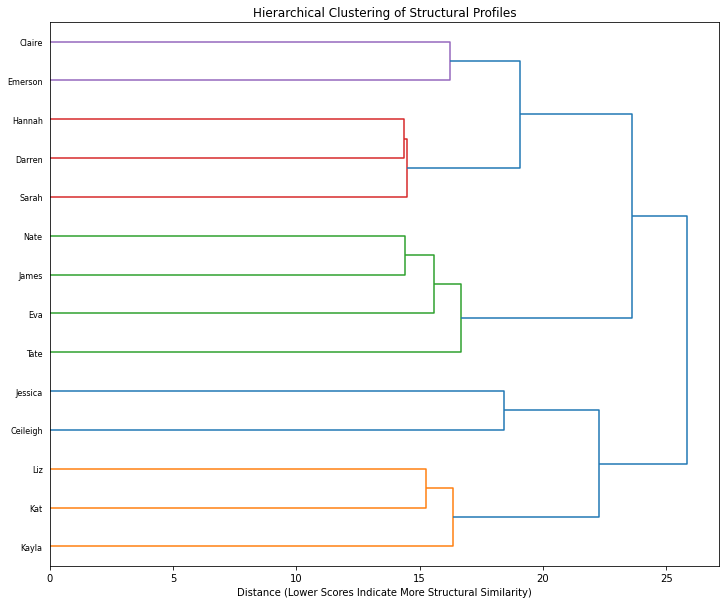

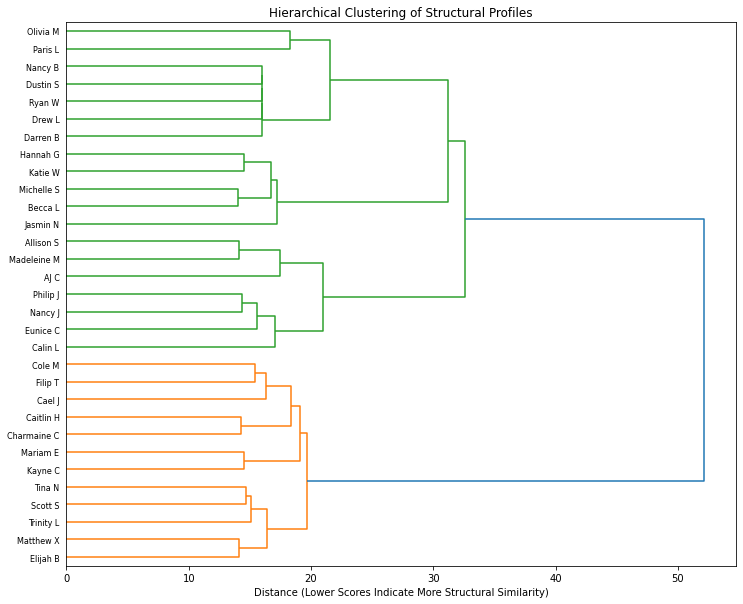

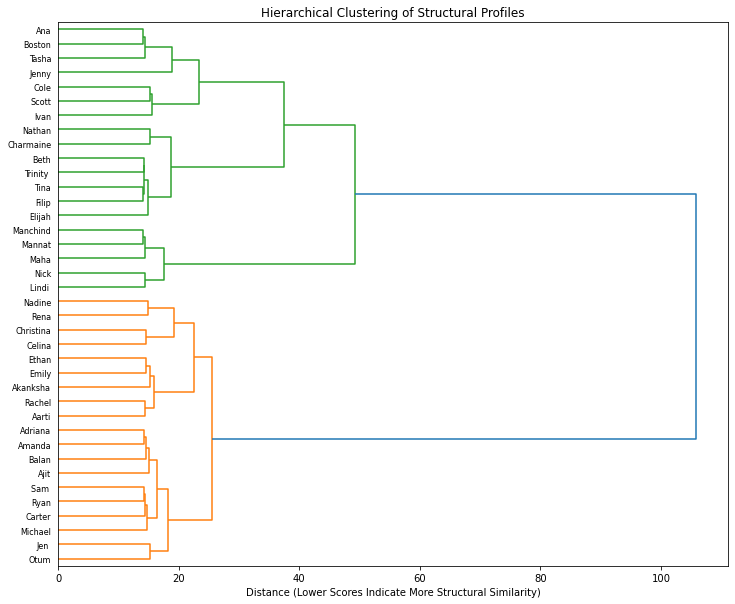

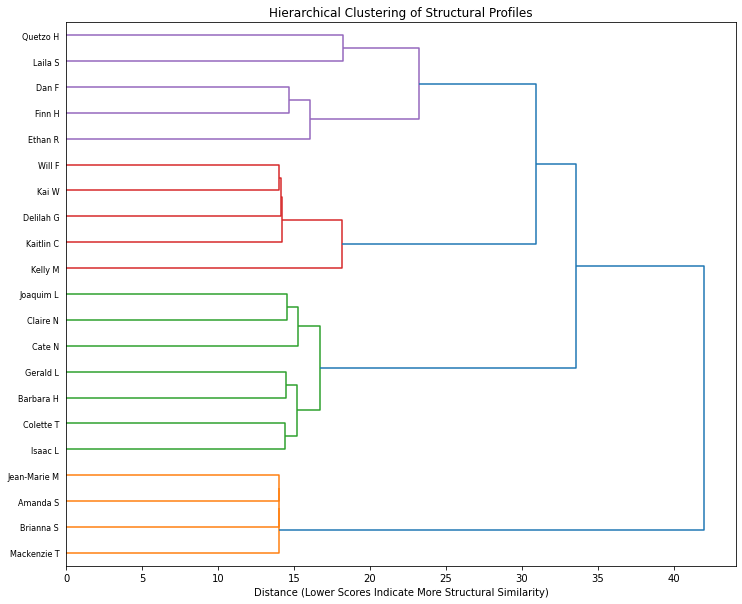

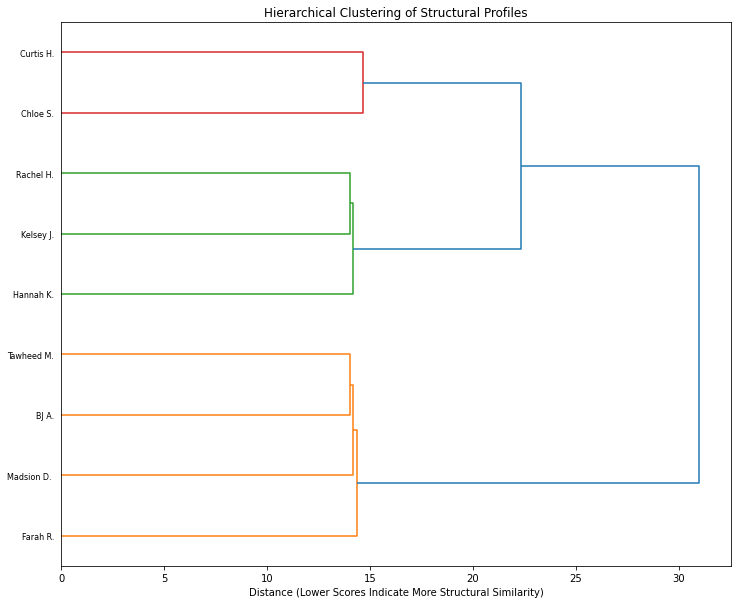

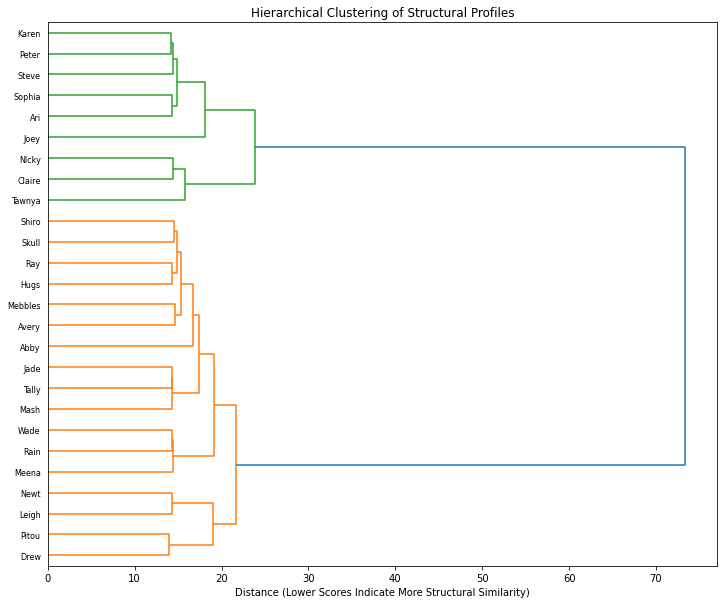

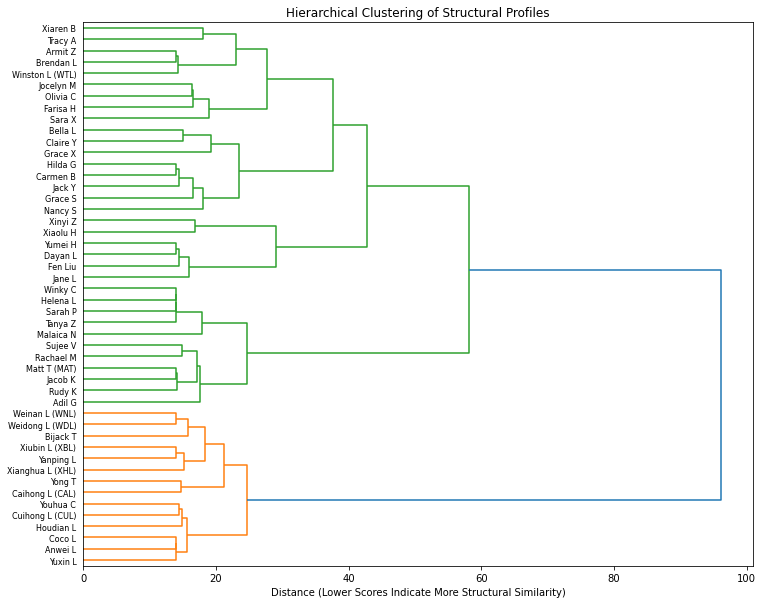

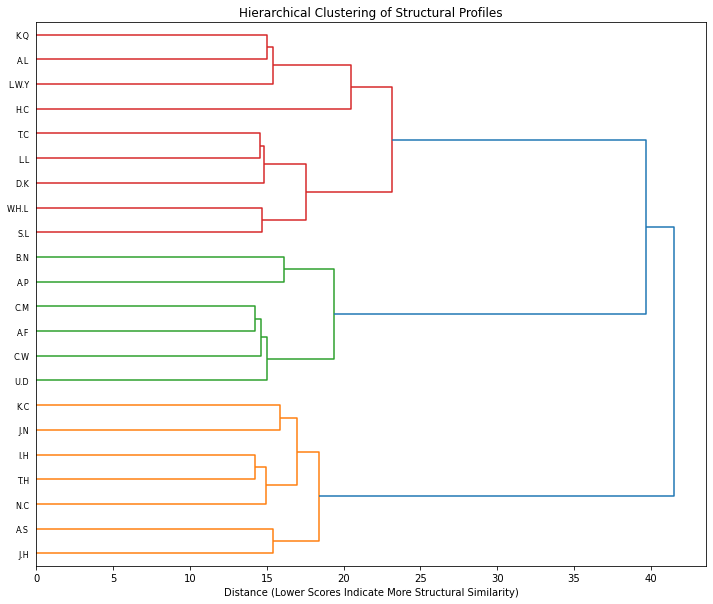

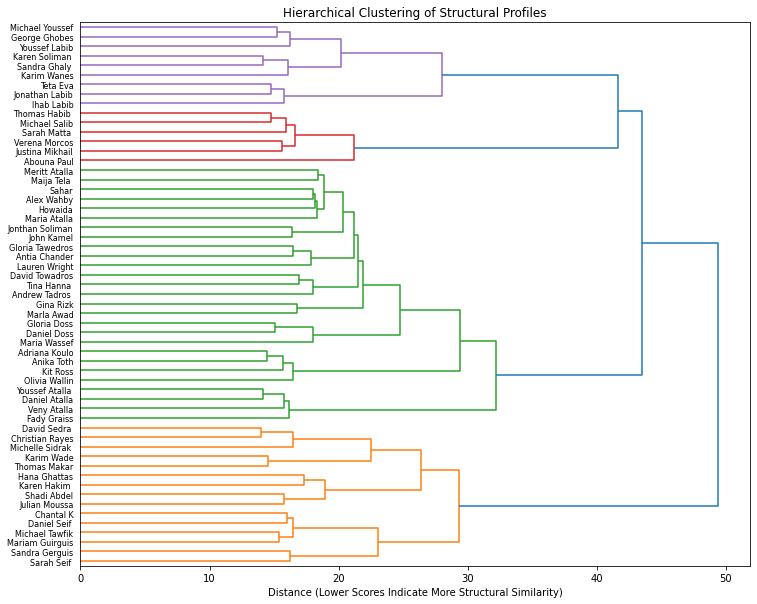

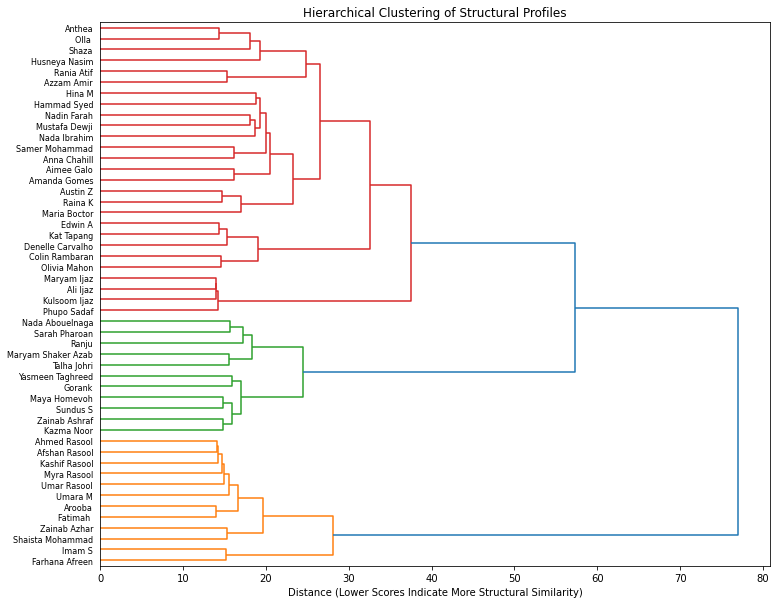

In [11]:
issues = []

for k, v in graphs.items():
    try:
        equiv(k)
    except:
        issues.append(k)

In [36]:
issues

[]

In [39]:
assignment_1('Schaefer_20904248')

Processing Schaefer_20904248...


/Users/johnmclevey/opt/anaconda3/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


Finished processing Schaefer_20904248
